# Final Project Submission

Please fill out:
* Student name: Marco Giuseppe Nasuto
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Jeff Herman
* Blog post URL: https://coral.marconasuto.com/


In [77]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import matplotlib.lines as mlines
import seaborn as sns
import missingno as msno
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, plot_confusion_matrix, precision_recall_curve, plot_precision_recall_curve, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.base import BaseEstimator
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.pipeline import Pipeline as imbPipe
import xgboost as xgb  
from sklearn.cluster import KMeans
%matplotlib inline

In [86]:
def Create_elbow_curve(data):
    """ Display elbow curve for K-means algo for given data """
        
    Sum_of_squared_distances = []
    K = range(1,15)

    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(data)
        Sum_of_squared_distances.append(km.inertia_)
    
    fig, ax = plt.subplots(dpi=300)
    ax.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [34]:
def confusionMatrix(modelfit, X, y_true, normalize='true', cmap=plt.cm.Blues, save=False):
    title = 'Confusion Matrix'
    #Confusion matix
    fig, ax = plt.subplots(dpi=300)
    plot_confusion_matrix(modelfit, 
                          X, y_true.reset_index().drop('index', axis=1).replace(yesno), 
                          cmap = cmap, 
                          normalize= normalize,
                          ax=ax)
    plt.title(title)
    if save:
        plt.savefig('./images/{}.png'.format(title), bbox_inches = "tight")

In [35]:
def churnSegments(X, 
                  y,
                  modelfit,
                  thrs,
                  CAC,
                  conv_rate,
                  numeric,
                  to_drop,
                  selected_thrs=[0.2, 0.32, 0.44, 0.56, 0.68, 0.8, 0.9, 0.95],
                  risk_thrs=[0, 0.7, 0.9, 1],
                  risk_labels=['Low-medium-risk', 'High risk', 'Very high risk']):

    camp_costs = {}
    pot_revs = {}
    pot_profs = {}
    table = {}
    yesno = {'Yes':1, 'No':0}
    ampu_verizon = 17
    
    y_reset = y.reset_index().drop('index', axis=1)
    X_rl_sd = X.copy(deep=True)
    X_rl_sd[numeric] = StandardScaler().fit_transform(X_rl_sd[numeric])
    X_rl_sd = pd.get_dummies(X_rl_sd, drop_first=True)
    X_rl_sd = X_rl_sd.drop(to_drop, axis=1)
    profs = []
    costs = []
    revs = []
    for conv_rate in conv_rates:
        for thr in thrs:
            raw_prob = xgbclassifier.predict(X_rl_sd)
            proba = list(modelfit.predict_proba(X_rl_sd)[:,1])
            label = [1 if x > thr else 0 for x in proba]
            prec_score = precision_score(y_reset.replace(yesno), raw_prob)

            delta_pred = pd.DataFrame(label, columns=['predicted_label'])
            delta_pred['predicted_prob'] = pd.DataFrame(proba, columns=['predicted_prob'])
            delta_pred['delta_pred'] = (delta_pred['predicted_label'] - y_reset.replace(yesno).transpose()).transpose()

            CAC = round(CAC, 0) #max marketing spend per identified churning users ($)

            df_risk = pd.concat([X_rl_sd, y_reset, delta_pred], axis=1)
            df_risk['Tenure'] = df_pre.loc[df_risk.index]['tenure']
            df_risk['MonthlyCharges_or'] = df_pre.loc[df_risk.index]['MonthlyCharges']
            df_risk['Risk level'] = pd.cut(df_risk['predicted_prob'], bins=risk_thrs, include_lowest=False, labels=risk_labels)
            df_risk = pd.concat([df_risk, df_pre['TotalCharges']], axis=1)
            df_risk['AvgTotChargesLeft'] = ((df_risk['TotalCharges'].sum()) / (df_risk['Tenure'].sum())) * (df_risk['Tenure'].median() - df_risk['Tenure'])
            df_risk.dropna(inplace=True)
            df_risk['targeting'] = df_risk['AvgTotChargesLeft'] - CAC
            df_risk['targeting'] = df_risk['targeting'] >= ampu_verizon #rows that are profitable

            targetable = df_risk[((df_risk['Risk level'] == 'High risk') |
                                  (df_risk['Risk level'] == 'Very high risk')) &
                                 (df_risk['targeting'] == True)]


            tot_camp_cost = len(targetable) * CAC
            pot_rev = targetable[targetable['delta_pred'] == 0]['AvgTotChargesLeft'].sum() * conv_rate #of the total potential revenues, we need to consider only those who will actually "convert"
            pot_prof = pot_rev - tot_camp_cost #- cost_fp

            costs.append(tot_camp_cost)
            revs.append(pot_rev)
            profs.append(pot_prof)
            
            camp_costs[conv_rate] = costs
            pot_revs[conv_rate] = revs
            pot_profs[conv_rate] = profs
            
        profs = []
        costs = []
        revs = []
    

    return df_risk, X_rl_sd, pot_profs, pot_revs, camp_costs

In [27]:
def Data_transformation_renaming(df_raw):
    """ Rename column names and transformed into proper format and return dataframe """
    df_cal = df_raw.copy()
    
    df_cal.rename(columns={'gender':'Gender'
                       ,'customerID':'CustomerID'
                       ,'Contract':'ContractType'
                       ,'InternetService':'InternetServiceType'
                       ,'tenure':'Tenure'
                      }
              ,inplace=True)


    df_cal['Partner'] = df_cal.Partner.map({'Yes':1,'No':0})
    df_cal['Dependents'] = df_cal.Dependents.map({'Yes':1,'No':0})

    df_cal['PhoneService'] = df_cal.PhoneService.map({'Yes':1,'No':0})
    df_cal['MultipleLines'] = df_cal.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})

    df_cal['InternetService'] = df_cal.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df_cal['OnlineSecurity'] = df_cal.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['OnlineBackup'] = df_cal.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['DeviceProtection'] = df_cal.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['TechSupport'] = df_cal.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['StreamingTV'] = df_cal.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['StreamingMovies'] = df_cal.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['PaperlessBilling'] = df_cal.PaperlessBilling.map({'Yes':1,'No':0})
    df_cal['Churn'] = df_cal.Churn.map({'Yes':1,'No':0})
    
    # Data mining
    #df_cal['IsContracted'] = df_cal.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    
    # Data transformation
    
    # Converting TotalCharges into Numeric, but some of the records are empty, so first we need to deal with them.
    df_cal.loc[df_cal['TotalCharges']==' ','TotalCharges'] = np.nan
    
    # First we convert TotalCharges to float and then replace with tenure * monthly charges
    df_cal['TotalCharges'] = df_cal['TotalCharges'].astype('float64')
    df_cal.loc[df_cal['TotalCharges'].isnull()==True,'TotalCharges'] = df_cal['MonthlyCharges'] * df_cal['Tenure']
    

    return df_cal

In [28]:
def Normalize_feature(feature):
    """ Return normalized features """
    return StandardScaler().fit_transform(feature)

In [29]:
class customTransformer():
    def __init__(self, to_drop=None, numeric=None, cat=None):
        self.to_drop = to_drop
        self.numeric = numeric
        self.cat = cat
        
    def transform(self, X, **transform_params):
        scaled_df = X.copy()
        sd = StandardScaler()
        oh = OneHotEncoder(sparse=False, handle_unknown='ignore')
        scaled_num = pd.DataFrame(sd.fit_transform(X[self.numeric]), columns=self.numeric)
        onehot = pd.DataFrame(oh.fit_transform(X[self.cat]), columns=oh.get_feature_names(self.cat))
        if to_drop:
            cpy_df = pd.concat([scaled_num, onehot], axis=1).drop(to_drop, axis=1)
        else:
            cpy_df = pd.concat([scaled_num, onehot], axis=1)
        return cpy_df

    def fit(self, X, y=None, **fit_params):
        return self

In [30]:
def class_report_adj(y_test, predicted_prob):
    for t in np.linspace(0.2,0.8, 6):
        print('t: {}'.format(t), classification_report(y_test, adjusted_classes(predicted_prob, thr=t)))

In [31]:
def adjusted_classes(y_pred, thr = 0.5):
    y_adj = [1 if i > thr else 0 for i in y_pred[:,1]]
    return y_adj

In [32]:
def report(modelfit, y_true, X, save=False, binary=False):
    #binary encoding of target variable
    if binary:
        onezero = {1:'Yes', 0:'No'}
        y_label = y_true.replace(onezero)
        predicted_label = pd.DataFrame(modelfit.predict(X)).replace(onezero)
    else:
        y_label = y_true
        yesno = {'Yes':1, 'No':0}
        y_true = y_true.replace(yesno)
        predicted_label = modelfit.predict(X)

    
    #Classification Report
    predicted_prob = modelfit.predict_proba(X)
    print(classification_report(y_label, predicted_label))

    #ROC curve and Precision-Recall Curve
    x = np.linspace(1,0,12)
    fpr, tpr, thr = roc_curve(y_true, predicted_prob[:,1])
    auc = roc_auc_score(y_true, predicted_prob[:,1], average='weighted')
    pr, rec, th_prrc = precision_recall_curve(y_true, predicted_prob[:,1])
    sns.set_context('talk', rc={'linewidth':2})
    sns.set_style('whitegrid')

    fig, ax = plt.subplots(1,2, figsize=(20,5))

    fig1_1 = sns.lineplot(fpr, tpr, ax=ax[0])
    fig1_1 = sns.lineplot(x,x, ax=ax[0])
    fig1_1.set_title('ROC');
    fig1_1.set(xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)')
    fig1_2 = plot_precision_recall_curve(modelfit, X, y_true, ax=ax[1])
    if save:
        plt.savefig('./images/ROC-curve-PR-curve.png', dpi=300)
    print('AUC ROC score: {}'.format(auc))
    class_report_adj(y_true, predicted_prob)
    mean_scores, n_k, mean_pos, base_prob, calib_score, refin_score = BrierScore(predicted_prob, y_true, save=save)
    scores = {'auc':auc, 'mean_scores':mean_scores, 'n_k':n_k, 'mean_pos':mean_pos, 'base_prob':base_prob, 'calib_score':calib_score, 'ref_score':refin_score}
    return scores

In [6]:
def BrierScore(predicted_prob, y_coded, bins=10, save=False):
    '''These functions allow to calculate the Brier score - as the sum of calibration and refinmeent (also known as discrimination).
    Calibration is: how much predicted probabilties for positive class are off w.r.t. observed frequency of true positive class instances'
    Refinement is: how concentrated predicted probabilities are towards 0 or 1. Refinement is related with the utility of the predictions.
    The lower the Brier Score, more confidently we can assess that the classifier asserts its predictions. 
    ''' 
    #slicing only predicted probabilities w.r.t. postive outcome (1)
    predicted_prob = predicted_prob[:,1]
    #binary encoding of target variable
    #yesno = {'Yes':1, 'No':0}
    #y_coded = y_coded.replace(yesno)
    y_coded = y_coded.iloc[:,0]

    #Binning (10 bins) and assigning each predicted probability to the correct bin
    bins=10
    bins = np.arange((bins + 1)) / bins
    digit_bins = np.digitize(predicted_prob, bins)

    #Initialised variables
    calib_score = 0 #calibration score
    mean_scores = [] #mean predicted positive scores binned 
    mean_pos = [] #mean true postive outcomes binned 
    n_k = [] #number of instances per bin

    refin_score = 0 #refinement score
    base_prob = np.mean(predicted_prob) #baseline probability

    for bin_i in np.unique(digit_bins):
        mean_score_bin = np.mean(predicted_prob[digit_bins == bin_i])
        mean_pos_bin = np.mean(y_coded[digit_bins == bin_i])
        n_k_instances = np.sum(digit_bins == bin_i)
        calib_score += (n_k_instances * (mean_score_bin - mean_pos_bin)**2)

        refin_score += (n_k_instances * (mean_pos_bin*(1 - mean_pos_bin)))
        #refin_score += n_k_instances * (mean_pos_bin - base_prob)**2

        mean_scores.append(mean_score_bin)
        n_k.append(n_k_instances)
        mean_pos.append(mean_pos_bin)

    calib_score = calib_score / len(predicted_prob)
    refin_score = refin_score / len(predicted_prob)
    

    print('Calibration score: {}'.format(calib_score), '\n Refinement score: {}'.format(refin_score))
    
    sns.set(style='whitegrid')
    sns.set_context('talk',rc={"lines.linewidth": 2})
    fig, ax = plt.subplots(1,2, figsize=(20,5))
    fig1_1 = sns.lineplot(mean_scores, mean_pos, ax=ax[0], alpha=0.7).set(xlim=(0,1))
    fig1_2 = sns.lineplot(mean_pos, mean_pos, ax=ax[0], color='r', alpha=0.7)
    fig2_1 = sns.distplot(digit_bins/10, kde=False);
    fig2_1.set_title('Histogram of predicted score');
    fig1_2.set_title('Calibration plot');
    fig2_1.set_xlabel('Score range');
    fig1_2.set(xlabel='Mean predicted scores', ylabel='Observed fraction of positives');
    if save:
        plt.savefig('./images/Calibration-plot-histogram.png', bbox_inches = "tight", dpi=300)
    return mean_scores, n_k, mean_pos, base_prob, calib_score, refin_score

In [7]:
def histhue(df, hue, save=False):
    sns.set_context('notebook', rc={'linewidth':1})
    palette = sns.color_palette("pastel")
    i = 0
    for col in df.columns:
        if col != hue:
            fig, ax = plt.subplots(1,2, figsize=(10,4))
            fig.tight_layout(w_pad=3)
            hist = sns.histplot(data=df, x=col, hue=hue, ax=ax[0], multiple='fill', stat='count', alpha=.8, palette=["powderblue", "coral"])
            hist_2 = sns.histplot(data=df, x=col, hue=hue, ax=ax[1], multiple='stack', stat='count', alpha=.8, palette=["powderblue", "coral"])
            hist.set_title('Histogram of {} by {}'.format(col, hue))
            hist_2.set_title('Histogram of {} by {}'.format(col, hue))
            hist.tick_params(axis='x', labelrotation=45)             
            hist_2.tick_params(axis='x', labelrotation=45) 
            if save:
                plt.savefig('./images/{}-by-{}.png'.format(col, hue), bbox_inches = "tight", dpi=300)

In [8]:
def statistics(df, target=None, jointplot=False, log=False, check_na=False):
    '''The fucntion returns a set of general statistics and information on a given dataframe df, target variable. When log=True the fucntion applies a log-transfromation to all numerical columns.:
    - .shape: shape of the dataframe
    - .info: dtype objects of each column and number of non-null objects
    - .describe: count, mean, std,  min, max, quartiles
    - .median: median of numerical columns in dataframe
    - nullity matrix: matrix that shows how filled variables are 
    - nullity dendogram: The dendrogram uses a hierarchical clustering algorithm (courtesy of scipy) to bin variables against one another by their nullity correlation (measured in terms of binary distance). At each step of the tree the variables are split up based on which combination minimizes the distance of the remaining clusters. The more monotone the set of variables, the closer their total distance is to zero, and the closer their average distance (the y-axis) is to zero. To interpret this graph, read it from a top-down perspective. Cluster leaves which linked together at a distance of zero fully predict one another's presence—one variable might always be empty when another is filled, or they might always both be filled or both empty, and so on. In this specific example the dendrogram glues together the variables which are required and therefore present in every record. Cluster leaves which split close to zero, but not at it, predict one another very well, but still imperfectly. If your own interpretation of the dataset is that these columns actually are or ought to be match each other in nullity (for example, as CONTRIBUTING FACTOR VEHICLE 2 and VEHICLE TYPE CODE 2 ought to), then the height of the cluster leaf tells you, in absolute terms, how often the records are "mismatched" or incorrectly filed—that is, how many values you would have to fill in or drop, if you are so inclined. As with matrix, only up to 50 labeled columns will comfortably display in this configuration. However the dendrogram more elegantly handles extremely large datasets by simply flipping to a horizontal configuration.
    - (isna.sum, perc_NaN): number of NaN values for each column and percentage of Nan values w.r.t each column total number of rows
    - (.duplicated, index_dupl): tuple with number of rows duplicated and indexes where .duplicated == True
    - .value_counts: Normalized unique values for each column in dataframe
    - .columns: list of columns of the dataframe
    - correlation matrix
    - boxplot: boxplots of numerical columns
    - hist: histograms of numerical columns
    - scatterplot: scatter plot for numerical columns
    - hist by target variable: histogram of columns with hue = target variable
\nParameters
----------
\ndf : DataFrame object
\ntarget: str, target column
    '''
    #mulitcollinearity with vif analysis 
    try:
        vif = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
        vif_df = pd.DataFrame()
        vif_df['vif'] = vif
        vif_df['features'] = df.columns
        print(vif_df.sort_values(by='vif', ascending=False))
    except: print('VIF analysis not possible at the moment. Please fix dtypes of columns.')

    duplicated_index = df[df.duplicated()].index
    print('Shape: ', df.shape)
    print('\ndtype objects of each column and number of non-null objects:')
    print('\n')
    print(df.info())
    print('\ncount, mean, std, min, max, quartiles:')
    print('\n{}'.format(df.describe()))
    print('\nMedian values of numerical columns in the dataframe:')
    print('\n{}'.format(df.median()))
    print('\nNumber of NaN values per column:\n')
    print(df.isna().sum(), '\n\nIn terms of percentage (%) for each column\n\n',
          df.apply(lambda x: ((x.isna().sum())/len(x))*100))
    if check_na == True:
        msno.matrix(df)
        msno.dendrogram(df)
    print('\nNormalized unique values for each column in dataframe')
    for col in df.columns:
        if df[col].dtypes == np.number:
            print('\nColumn name: {}\n\n{}'.format(
                col, df[col].value_counts(normalize=True, dropna=False)))
        else:
            print('\nColumn name: {}\n\n{}'.format(
                col, df[col].value_counts(normalize=True, dropna=False)))
    print('Duplicated rows in the dataframe: ', df.duplicated().sum(),
          'Indexes where duplicated', duplicated_index)
    print('List of columns in the dataframe:')
    print(df.columns)
    plt.figure(figsize=(20, 20))
    sns.heatmap(df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1)
    plt.figure(figsize=(20, 20))
    if log == True:
        logtransform(df)
    if (df.dtypes == bool).any():
        print('There is at least a boolean column')    
    df.select_dtypes(exclude=bool).hist(figsize=(20, 20))
    df.select_dtypes(exclude=bool).boxplot(figsize=(20, 20))
    for col in df.columns:
        try:
            if jointplot:
                g = sns.jointplot(x=col, y=target, data=df)
                #plt.title('Feature: {}'.format(col))
        except:
            print('{} is not a numerical column'.format(col))
    if target != None:
        try:
            histhue(df, target)
        except:
            print('It hasn\'t been possible to visualize histograms of each column w.r.t. {}'.format(target))
    return duplicated_index

In [9]:
class ClfSwitcher(BaseEstimator):

    def __init__(
        self, 
        estimator = RandomForestClassifier(),
    ):
        """
        A Custom BaseEstimator that can switch between classifiers.
        :param estimator: sklearn object - The classifier
        """ 

        self.estimator = estimator


    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self


    def predict(self, X, y=None):
        return self.estimator.predict(X)


    def predict_proba(self, X):
        return self.estimator.predict_proba(X)


    def score(self, X, y):
        return self.estimator.score(X, y)

# Load data

In [54]:
#directory where data is
os.chdir('../data')

In [68]:
with open('./processed/todrop.pkl', 'rb') as f:
    to_drop = pickle.load(f)
    
with open('./processed/cat.pkl', 'rb') as f:
    cat = pickle.load(f)

In [15]:
df_full = pd.read_csv('./processed/telcom-dataset.csv')
df_full.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [44]:
df_dum = pd.read_csv('./processed/telcom-dataset-dummies.csv')
df_dum.head()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male  \
0              0       1           29.85         29.85            0   
1              0      34           56.95       1889.50            1   
2              0       2           53.85        108.15            1   
3              0      45           42.30       1840.75            1   
4              0       2           70.70        151.65            0   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0            1               0                 0   
1            0               0                 1   
2            0               0                 1   
3            0               0                 0   
4            0               0                 1   

   MultipleLines_No phone service  MultipleLines_Yes  ...  \
0                               1                  0  ...   
1                               0                  0  ...   
2                               0                  0  ...   
3                               1                  0  ...   
4                               0                  0  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                                0                0   
1                                0                0   
2                                0                0   
3                                0                0   
4                                0                0   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                    0                    0   
1                                    0                    0   
2                                    0                    0   
3                                    0                    0   
4                                    0                    0   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                  0                  0                     1   
1                  1                  0                     0   
2                  0                  0                     1   
3                  1                  0                     0   
4                  0                  0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 30 columns]

In [16]:
df_pre = df_full.drop('Churn', axis =1)
X = df_pre.copy()
y = df_full['Churn']

**ARPU - Average Revenue Per User** 

ARPU = Total Revenue / # of Users

CaC is 4x times ARPU. ARPU sets the threshold for marketing spending per person for retantion. 


*sources:*

*ARPU https://blog.hubspot.com/service/arpu*

*CAC for Telco Companies https://stlpartners.com/research/telco-economics-mobile-churn-rates-and-reduction-strategies/*

In [18]:
tot_rev = df_pre['MonthlyCharges'].sum()
ARPU = tot_rev / (len(df_pre))
CAC = 4*ARPU
print('Average Monthly ARPU is : {}$'.format(round(ARPU,0)))
print('Threshold is = CAC (Cost per ACquistition): {}$'.format(round(CAC,0)))

Average Monthly ARPU is : 65.0$
Threshold is = CAC (Cost per ACquistition): 259.0$


## Cluster analysis

In [19]:
df_churn = pd.DataFrame(y)

In [25]:
df_cal = df_pre.copy(deep=True)
df_cal.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  
0              Yes           Electronic check           29.85         29.85  
1               No               Mailed check           56.95       1889.50  
2              Yes               Mailed check           53.85        108.15  
3               No  Bank transfer (automatic)           42.30       1840.75  
4              Yes           Electronic check           70.70        151.65

In [26]:
df_cal = pd.concat([df_cal, df_churn], axis=1)

In [36]:
df_cal = Data_transformation_renaming(df_cal)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [37]:
df_cal = df_cal.drop('InternetServiceType', axis=1)

In [38]:
df_cal['Tenure_norm'] = Normalize_feature(df_cal[['Tenure']])
df_cal['MonthlyCharges_norm'] = Normalize_feature(df_cal[['MonthlyCharges']])
df_cal.head()

Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
0  Female              0        1           0       1             0   
1    Male              0        0           0      34             1   
2    Male              0        0           0       2             1   
3    Male              0        0           0      45             0   
4  Female              0        0           0       2             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0              0               0             1                 0  ...   
1              0               1             0                 1  ...   
2              0               1             1                 0  ...   
3              0               1             0                 1  ...   
4              0               0             0                 0  ...   

   StreamingMovies    ContractType  PaperlessBilling  \
0                0  Month-to-month                 1   
1                0        One year                 0   
2                0  Month-to-month                 1   
3                0        One year                 0   
4                0  Month-to-month                 1   

               PaymentMethod  MonthlyCharges TotalCharges  Churn  \
0           Electronic check           29.85        29.85      0   
1               Mailed check           56.95      1889.50      0   
2               Mailed check           53.85       108.15      1   
3  Bank transfer (automatic)           42.30      1840.75      0   
4           Electronic check           70.70       151.65      1   

   InternetService  Tenure_norm  MonthlyCharges_norm  
0                1    -1.280248            -1.161694  
1                1     0.064303            -0.260878  
2                1    -1.239504            -0.363923  
3                1     0.512486            -0.747850  
4                1    -1.239504             0.196178  

[5 rows x 22 columns]

In [39]:
df_cal.head()

Gender  SeniorCitizen  Partner  Dependents  Tenure  PhoneService  \
0  Female              0        1           0       1             0   
1    Male              0        0           0      34             1   
2    Male              0        0           0       2             1   
3    Male              0        0           0      45             0   
4  Female              0        0           0       2             1   

   MultipleLines  OnlineSecurity  OnlineBackup  DeviceProtection  ...  \
0              0               0             1                 0  ...   
1              0               1             0                 1  ...   
2              0               1             1                 0  ...   
3              0               1             0                 1  ...   
4              0               0             0                 0  ...   

   StreamingMovies    ContractType  PaperlessBilling  \
0                0  Month-to-month                 1   
1                0        One year                 0   
2                0  Month-to-month                 1   
3                0        One year                 0   
4                0  Month-to-month                 1   

               PaymentMethod  MonthlyCharges TotalCharges  Churn  \
0           Electronic check           29.85        29.85      0   
1               Mailed check           56.95      1889.50      0   
2               Mailed check           53.85       108.15      1   
3  Bank transfer (automatic)           42.30      1840.75      0   
4           Electronic check           70.70       151.65      1   

   InternetService  Tenure_norm  MonthlyCharges_norm  
0                1    -1.280248            -1.161694  
1                1     0.064303            -0.260878  
2                1    -1.239504            -0.363923  
3                1     0.512486            -0.747850  
4                1    -1.239504             0.196178  

[5 rows x 22 columns]

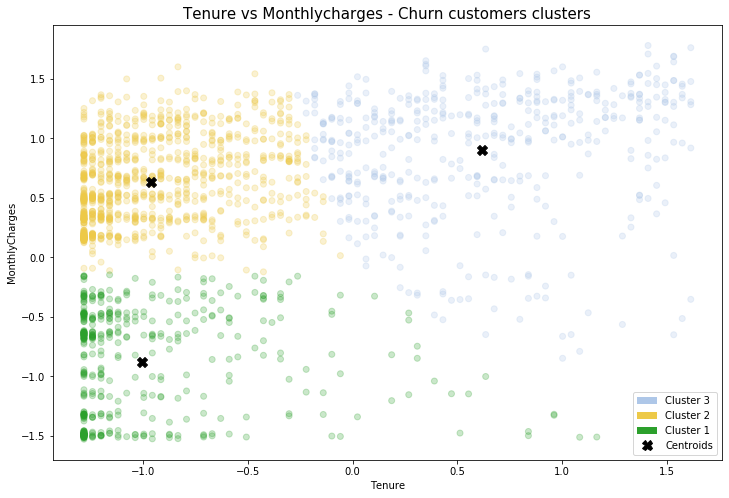

In [40]:
n_clusters = 3
random_state=42
df_cal = df_cal.dropna()
data = df_cal[df_cal.Churn==1][['Tenure_norm','MonthlyCharges_norm']]
x_title='Tenure'
y_title='MonthlyCharges'
plotColor = ['#aec7e8', '#edc948','#2ca02c', 'k']
chart_title = 'Tenure vs Monthlycharges - Churn customers clusters'

kmeans = KMeans(n_clusters=n_clusters # No of cluster in data
                    , random_state = random_state # Selecting same training data
                   ) 

kmeans.fit(data)
kmean_colors = [plotColor[c] for c in kmeans.labels_]


fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(x= x_title + '_norm'
            , y= y_title + '_norm'
            , data=data 
            , c= kmean_colors # color of data points
            , alpha=0.25) # transparancy of data points


classes = ['Cluster 3','Cluster 2','Cluster 1', 'Centroids']
class_colours = plotColor
recs = []
for i in range(0,len(class_colours)):
    if i == range(0,len(class_colours))[-1]:
        recs.append(mlines.Line2D([], 
                                  [], 
                                  color='k', 
                                  marker='X', 
                                  linestyle='None', 
                                  markersize=10))
    else: recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
ax.legend(recs,classes,loc=4)
plt.xlabel(x_title)
plt.ylabel(y_title)

ax.scatter(x=kmeans.cluster_centers_[:,0]
            , y=kmeans.cluster_centers_[:,1]
            , color='black'
            , marker='X' # Marker sign for data points
            , s=100 # marker size
           )


plt.title(chart_title,fontsize=15)
plt.savefig('./images/{}.png'.format(chart_title), dpi=300)
plt.show()

df_cal['Cluster'] = -1
df_cal.loc[(df_cal.Churn==1),'Cluster'] = kmeans.fit_predict(df_cal[df_cal.Churn==1][['Tenure_norm','MonthlyCharges_norm']])

In [41]:
df_cal[df_cal['Cluster'] != -1]['Cluster'].value_counts(normalize=True)

1    0.508293
2    0.248796
0    0.242911
Name: Cluster, dtype: float64

VIF analysis not possible at the moment. Please fix dtypes of columns.
Shape:  (950, 23)

dtype objects of each column and number of non-null objects:


<class 'pandas.core.frame.DataFrame'>
Int64Index: 950 entries, 4 to 7030
Data columns (total 23 columns):
Gender                 950 non-null object
SeniorCitizen          950 non-null int64
Partner                950 non-null int64
Dependents             950 non-null int64
Tenure                 950 non-null int64
PhoneService           950 non-null int64
MultipleLines          950 non-null int64
OnlineSecurity         950 non-null int64
OnlineBackup           950 non-null int64
DeviceProtection       950 non-null int64
TechSupport            950 non-null int64
StreamingTV            950 non-null int64
StreamingMovies        950 non-null int64
ContractType           950 non-null object
PaperlessBilling       950 non-null int64
PaymentMethod          950 non-null object
MonthlyCharges         950 non-null float64
TotalCharges          

Int64Index([1734, 3296, 5750, 6258, 6753, 6913], dtype='int64')

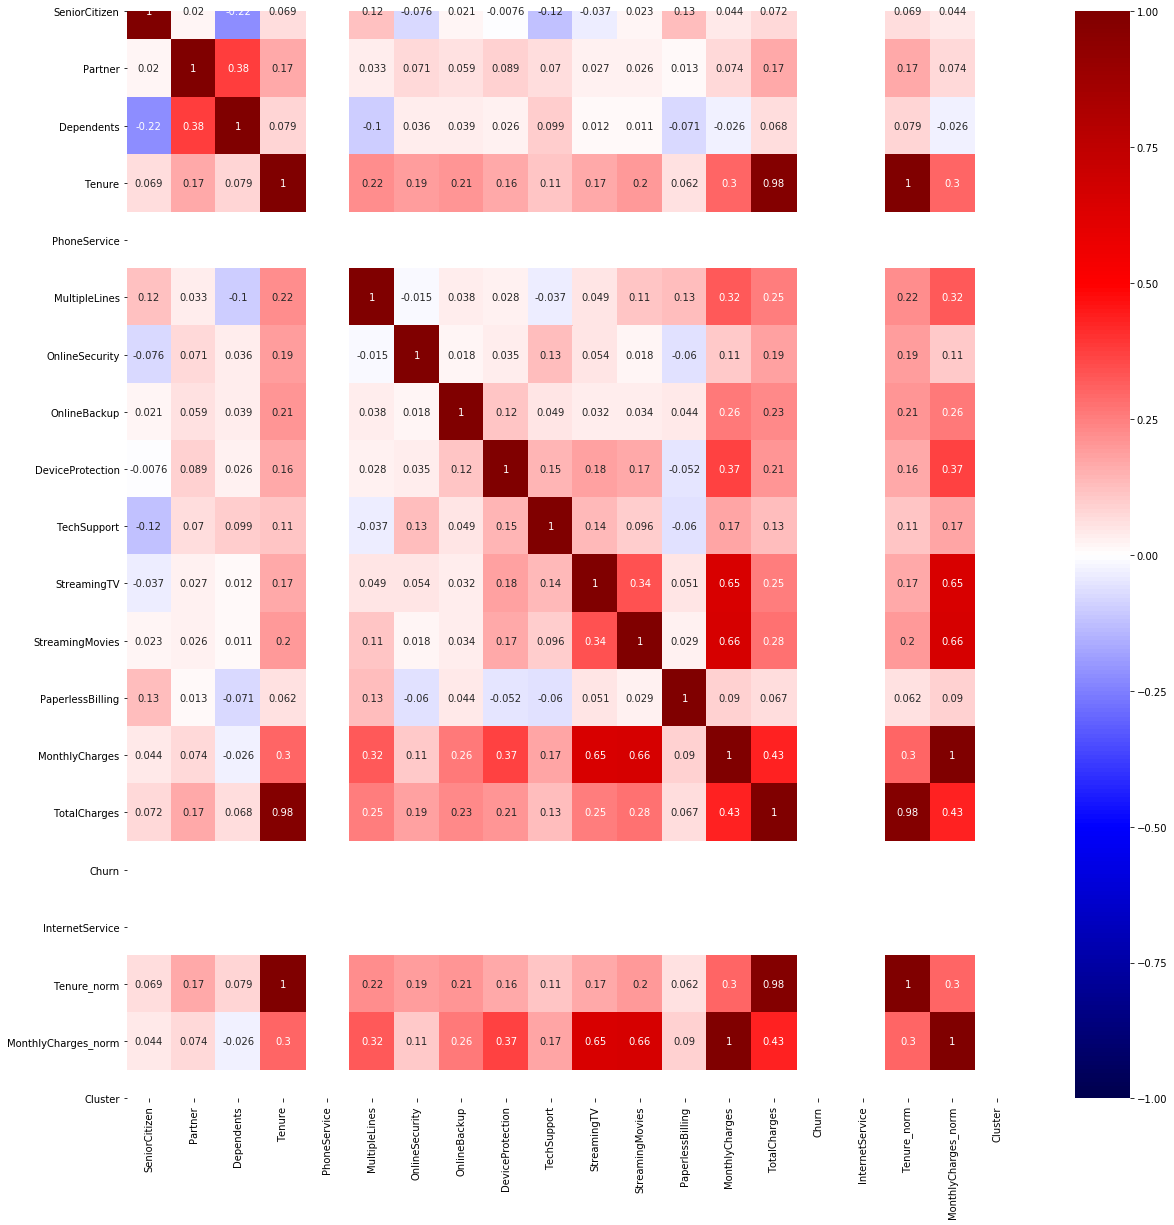

<Figure size 1440x1440 with 0 Axes>

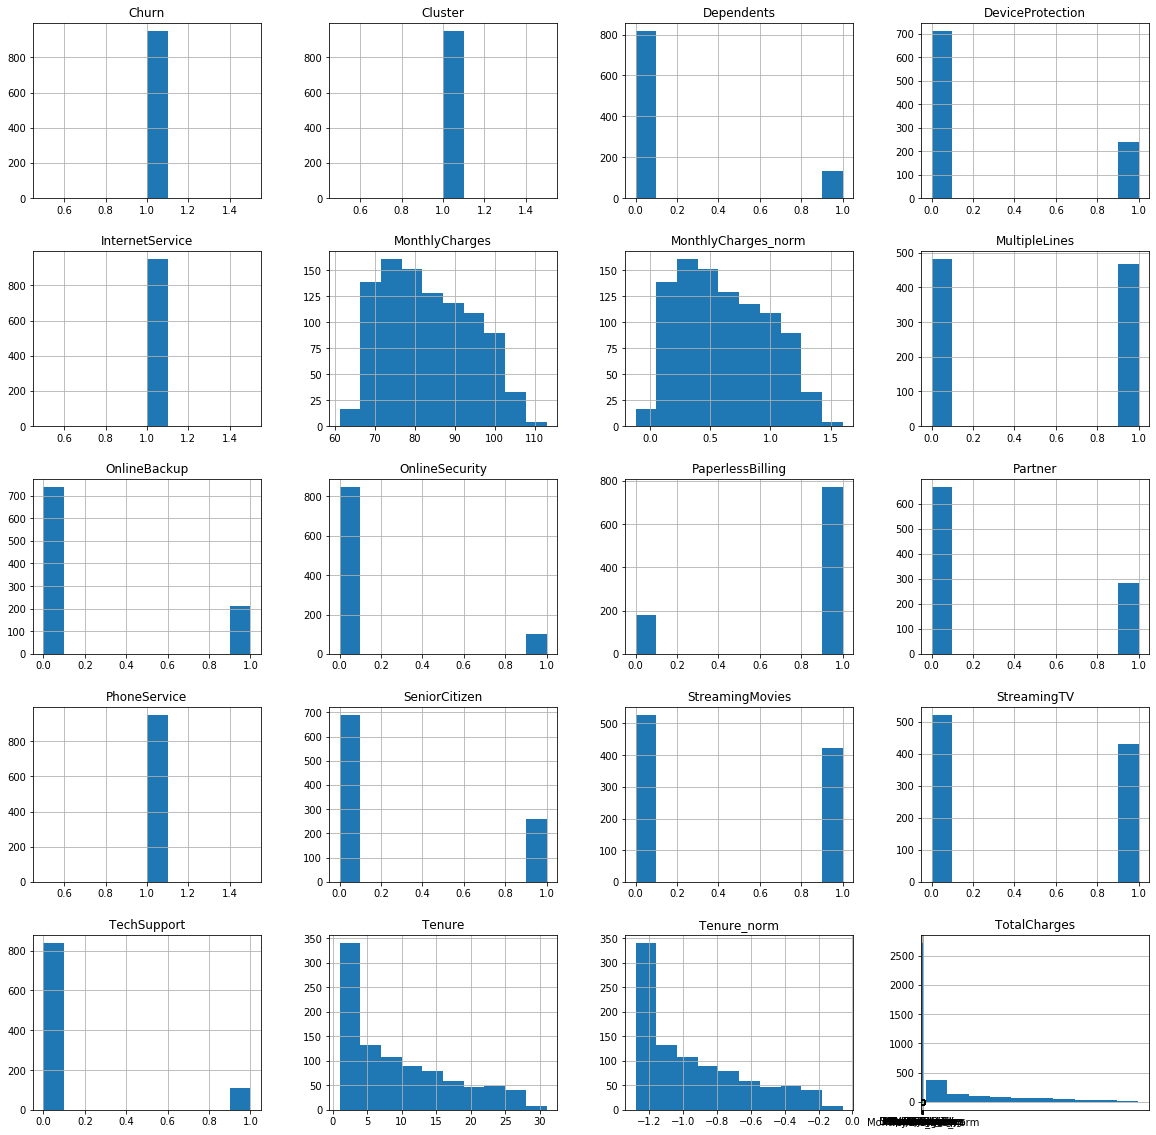

In [42]:
statistics(df_cal[df_cal['Cluster'] == 1])

- Half of them has multiple lines
- They tend not to have partners and dependents
- They tend to have a higher median value of SeniorCitizen w.r.t. Cluster==2 or 1
- They spend quite a lot per month, they churn soon
- They have month-to-month contract
- They use fiber optic
- They don't use OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport
- They use StreamingMovies and StreamingTV more than cluster 2
- They tend to use electronic payment methods, although less than cluster 0

VIF analysis not possible at the moment. Please fix dtypes of columns.
Shape:  (465, 25)

dtype objects of each column and number of non-null objects:


<class 'pandas.core.frame.DataFrame'>
Int64Index: 465 entries, 2 to 7026
Data columns (total 25 columns):
Gender                 465 non-null object
SeniorCitizen          465 non-null int64
Partner                465 non-null int64
Dependents             465 non-null int64
Tenure                 465 non-null int64
PhoneService           465 non-null int64
MultipleLines          465 non-null int64
InternetServiceType    465 non-null object
OnlineSecurity         465 non-null int64
OnlineBackup           465 non-null int64
DeviceProtection       465 non-null int64
TechSupport            465 non-null int64
StreamingTV            465 non-null int64
StreamingMovies        465 non-null int64
ContractType           465 non-null object
PaperlessBilling       465 non-null int64
PaymentMethod          465 non-null object
MonthlyCharges         

Int64Index([964, 1338, 4098, 4476, 6518, 6609], dtype='int64')

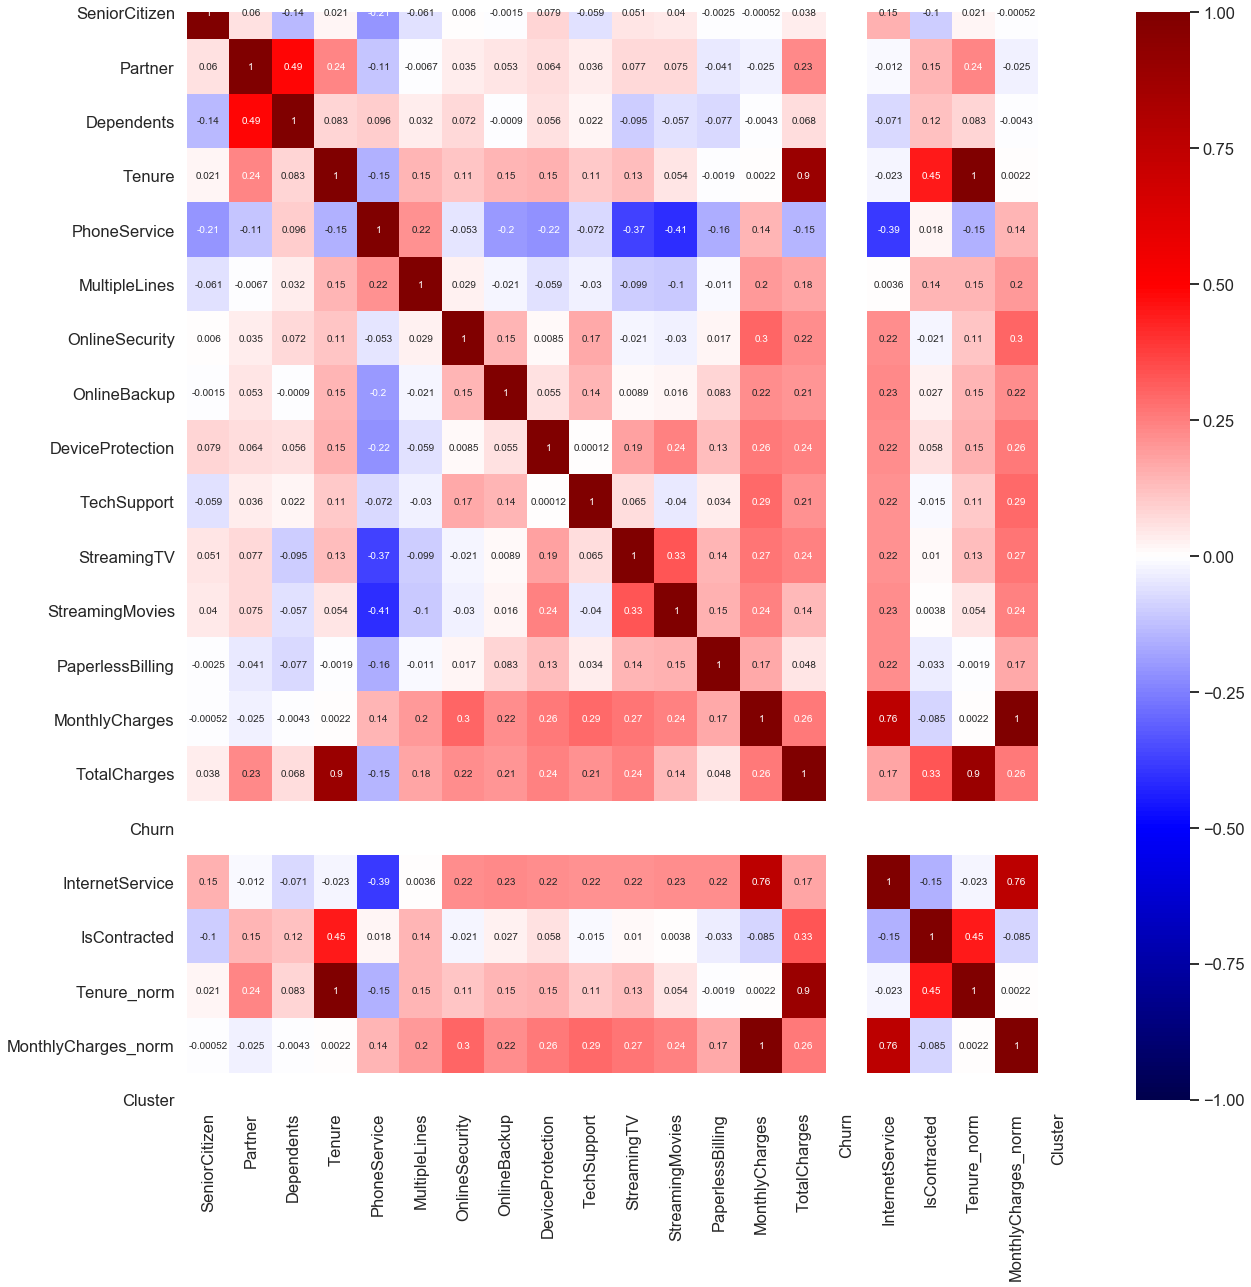

<Figure size 1440x1440 with 0 Axes>

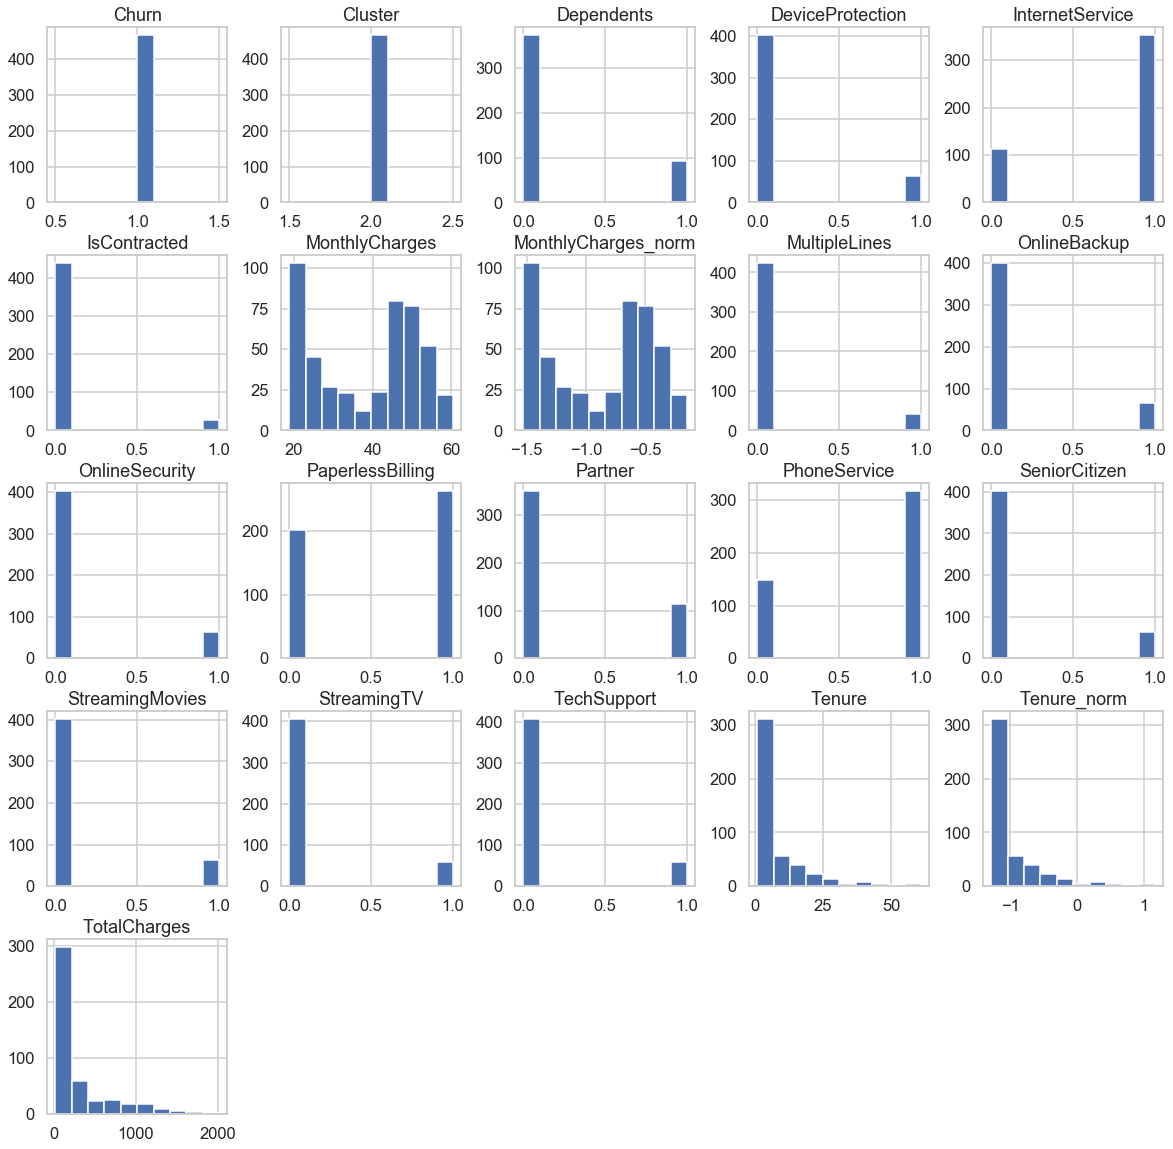

In [485]:
statistics(df_cal[df_cal['Cluster'] == 2])

- They tend not to have partners and dependents
- They tend not to be SeniorCitizen
- They spend less per month, they churn soon
- They have month-to-month contract
- They use DSL
- They don't use OnlineSecurity, OnlineBackup, DeviceProtection, TechSuppor, StreamingTV, StreamingMovies
- They tend to use PaperlessBilling less 
- They tend to use Mailed check more than the other two clusters


VIF analysis not possible at the moment. Please fix dtypes of columns.
Shape:  (454, 25)

dtype objects of each column and number of non-null objects:


<class 'pandas.core.frame.DataFrame'>
Int64Index: 454 entries, 8 to 7034
Data columns (total 25 columns):
Gender                 454 non-null object
SeniorCitizen          454 non-null int64
Partner                454 non-null int64
Dependents             454 non-null int64
Tenure                 454 non-null int64
PhoneService           454 non-null int64
MultipleLines          454 non-null int64
InternetServiceType    454 non-null object
OnlineSecurity         454 non-null int64
OnlineBackup           454 non-null int64
DeviceProtection       454 non-null int64
TechSupport            454 non-null int64
StreamingTV            454 non-null int64
StreamingMovies        454 non-null int64
ContractType           454 non-null object
PaperlessBilling       454 non-null int64
PaymentMethod          454 non-null object
MonthlyCharges         

Int64Index([], dtype='int64')

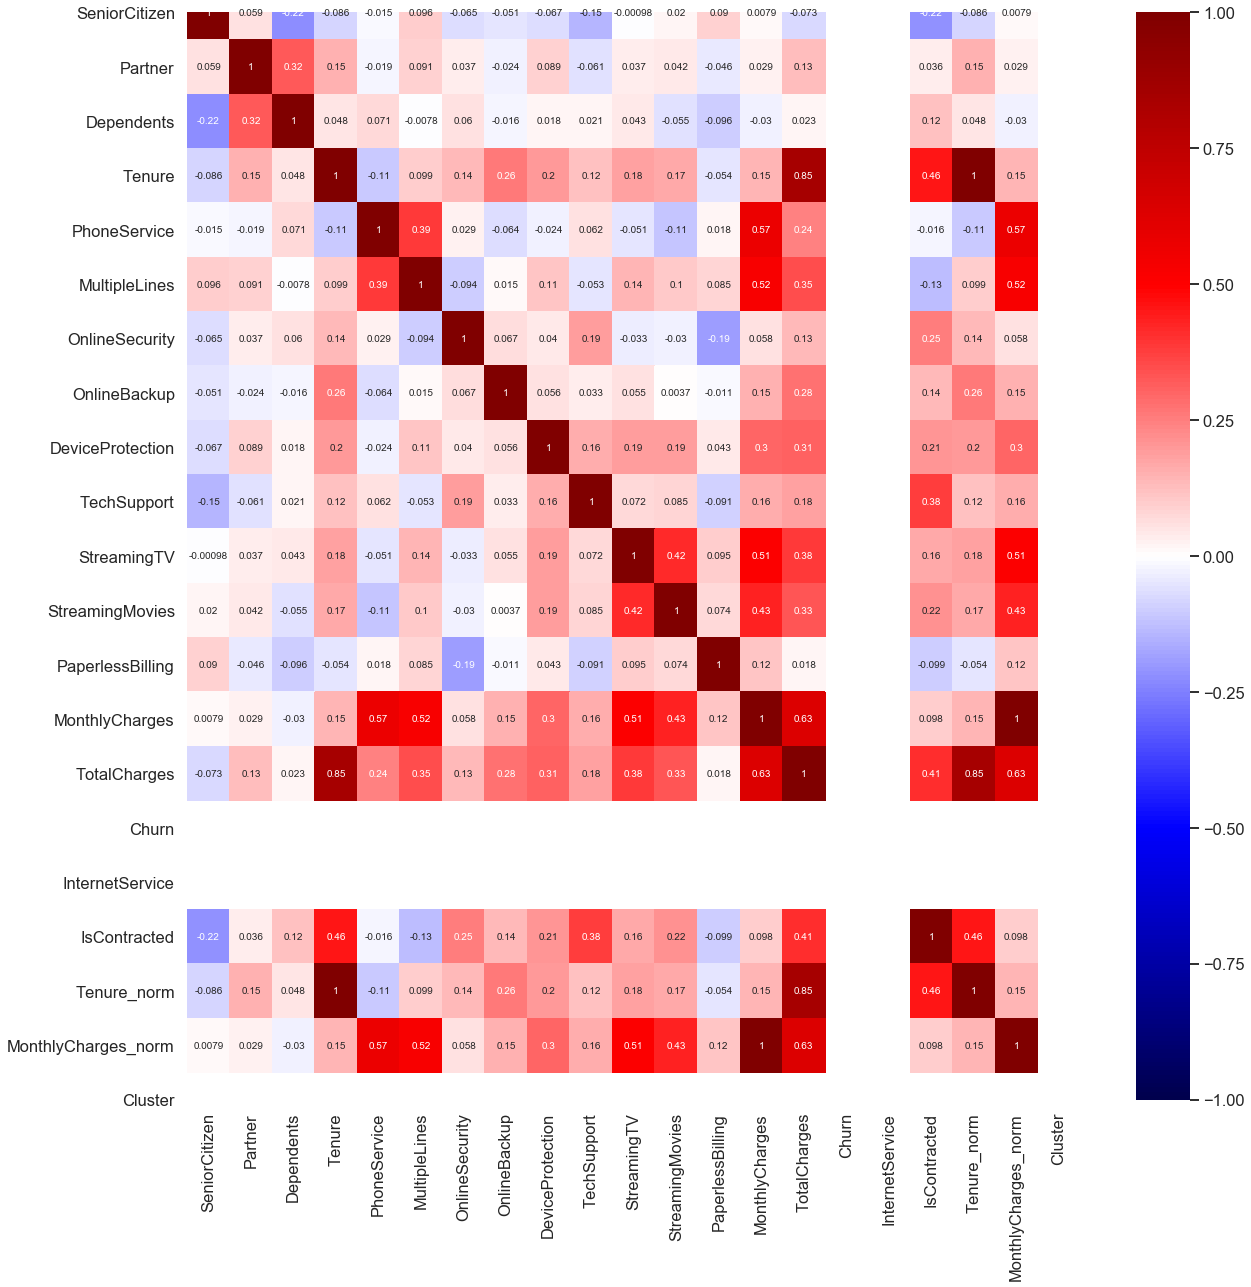

<Figure size 1440x1440 with 0 Axes>

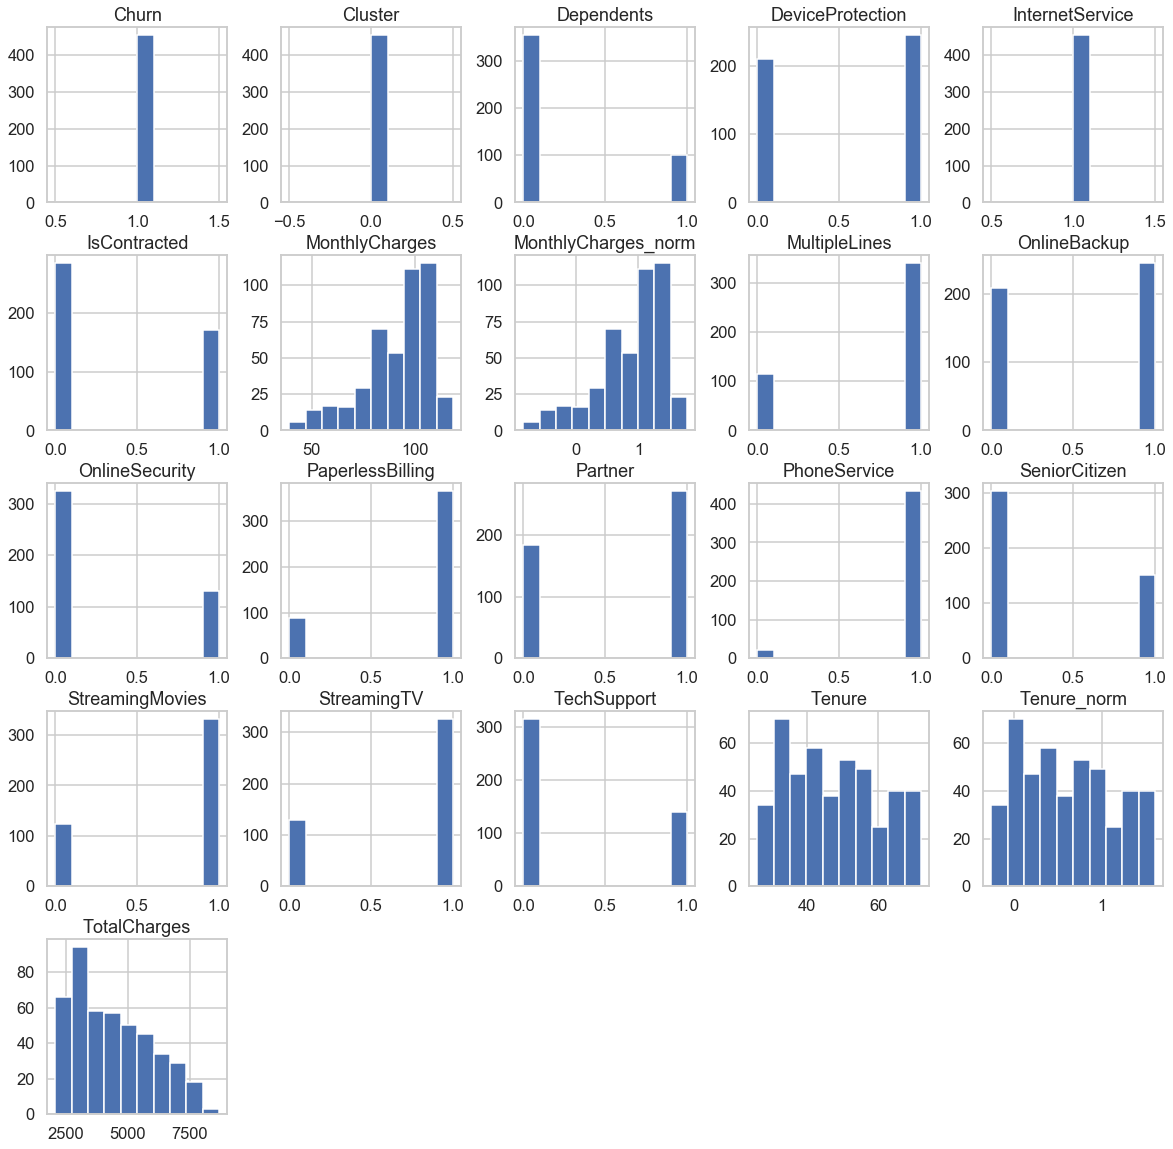

In [487]:
statistics(df_cal[df_cal['Cluster'] == 0])

Tech-savy families?
- They spent a lot throughout the years
- They have multiple lines
- They tend to have partners and more dependents than the other clusters
- They tend to have a higher median value of SeniorCitizen w.r.t. Cluster==2 or 1
- They spend a lot per month, they churn late
- They have month-to-month contract
- They use fiber optic or DSL
- They use OnlineBackup, DeviceProtection, StreamingTV, StreamingMovies
- They use TechSupport and OnlineSecurity more than the other clusters.
- They tend to have more one or more-year contracts
- They have the highest percentage of PaperlessBilling
- They pay with electronic methods


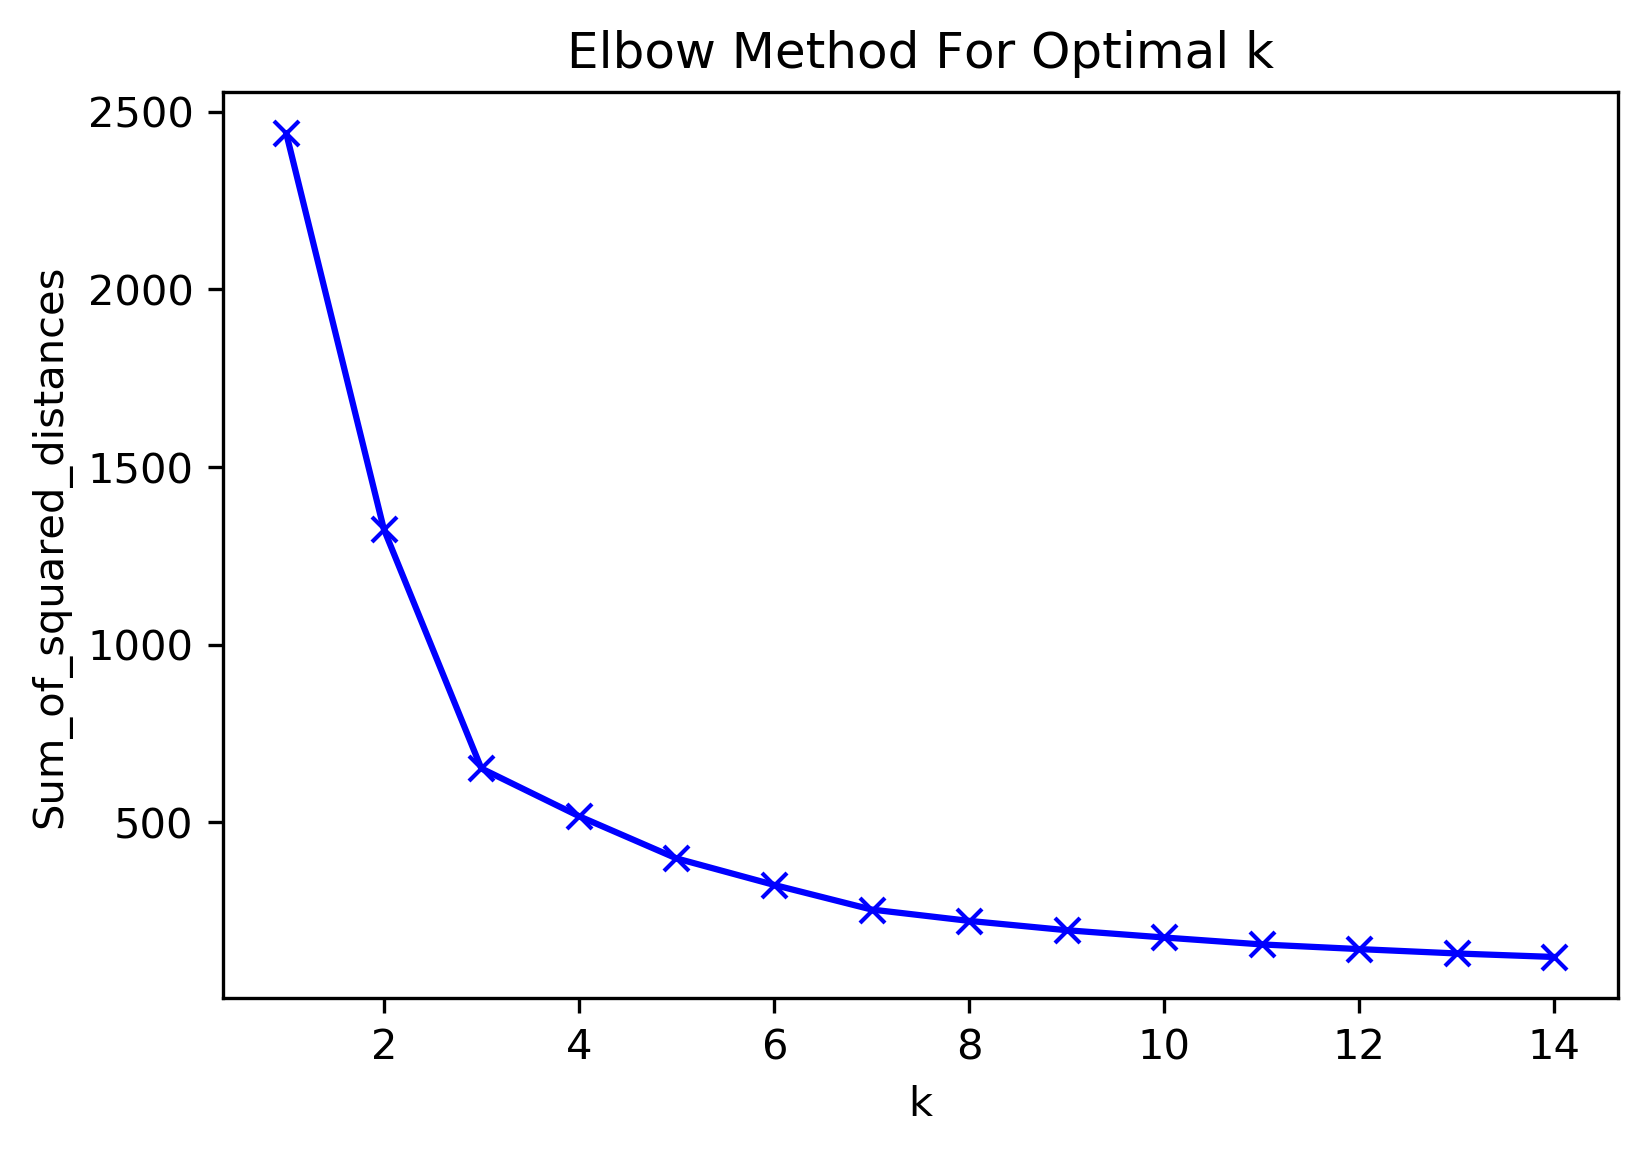

In [87]:
Create_elbow_curve(df_cal[df_cal.Churn==1][['Tenure_norm','MonthlyCharges_norm']])

In [76]:
silhouette_score(df_cal[df_cal.Churn==1][['Tenure_norm','MonthlyCharges_norm']], df_cal[df_cal.Churn==1]['Cluster'])

0.5130061455470235

## Baseline modeling

- Pipeline initialisation
- RandomSearchCV with Stratified Cross Validation to: 
         a) select best classifier amid: 
                   - RandomForest
                   - KNN
                   - SVM
                   - Logistic Regression
                   - XGBoost
         b) range of parameters sub-optimal
    
- GridSearchCV with Stratified Nested Cross Validation on best classifier 

In [65]:
#list of columns to keep (to be used with custom selector)
to_keep = list(Counter(df_dum.columns) - Counter(to_drop))

In [69]:
#list of numerical columns to keep (to be used with custom selector)
numeric = list((Counter(df_pre.loc[:,df_pre.columns !='Churn'].columns) - Counter(cat) - Counter(dict([('SeniorCitizen',1)]))).keys())

In [70]:
#steps for pipeline
t = [('custom', customTransformer(to_drop=to_drop, numeric=numeric, cat=cat)), 
     ('clfswitcher', ClfSwitcher())]

In [71]:
#pipeline initialisation
pipeline = Pipeline(t)
pipeline

Pipeline(steps=[('custom', <__main__.customTransformer object at 0x1a220cdb00>),
                ('clfswitcher', ClfSwitcher())])

In [72]:
#Parameters for RandomSearchCV
##Random Forest
n_estimators = [int(x) for x in np.linspace(100, 2000, 5)]
max_depth = [int(x) for x in np.linspace(10, 100, 5)]
max_depth.append(None)
min_samples_split = [int(x) for x in np.linspace(2, 10, 3)]
min_samples_leaf = [int(x) for x in np.linspace(1,5,3)]
random_state = [42]
max_features = ['auto', 'sqrt']
class_weight= ['balanced']

#K-Nearest Neighbors
n_neighbors = [3, 5, 9, 13, 17, 21] 
metric = ['euclidean', 'manhattan', 'minkowski'] 

#SVC
C = [100, 10, 1.0, 0.1, 0.001]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

#Logistic Regression
penalty = ['l1', 'l2', 'elasticnet']
C_logreg = [100, 10, 1.0, 0.1, 0.01]

#XGBoost
max_depth = [2, 5, 7, 10]
learning_rate =  [0.1, 0.2, 0.5]
#XGBoost fit params
early_stopping_rounds = 5

In [73]:
random_grid = [{'clfswitcher__estimator': [RandomForestClassifier()],
               'clfswitcher__estimator__class_weight': class_weight,
               'clfswitcher__estimator__random_state': random_state,
               'clfswitcher__estimator__max_depth': max_depth,
               'clfswitcher__estimator__min_samples_split': min_samples_split,
               'clfswitcher__estimator__min_samples_leaf': min_samples_leaf,
               'clfswitcher__estimator__max_features': max_features
               },
              {'clfswitcher__estimator': [KNeighborsClassifier()],
               'clfswitcher__estimator__n_neighbors': n_neighbors,
               'clfswitcher__estimator__metric': metric
              },
              {'clfswitcher__estimator': [SVC()],
               'clfswitcher__estimator__C': C,
               'clfswitcher__estimator__kernel': kernels
              },
              {'clfswitcher__estimator': [LogisticRegression()],
               'clfswitcher__estimator__penalty': penalty,
               'clfswitcher__estimator__C': C_logreg
              },
              {'clfswitcher__estimator': [xgb.XGBClassifier()],
              'clfswitcher__estimator__learning_rate': learning_rate,
              'clfswitcher__estimator__max_depth': max_depth
              }]

fit_params = [{'clfswitcher__estimator__early_stopping_rounds': early_stopping_rounds}]

In [387]:
inner_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
rf_random = RandomizedSearchCV(estimator=pipeline, param_distributions=random_grid, n_iter=100, cv=inner_cv, verbose=2, random_state=42, n_jobs=None)

In [388]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X,y, test_size=0.2, stratify=y, random_state=42)

In [389]:
rf_random.fit(X_train_rf, y_train_rf)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC() 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC(), total=   1.0s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC() 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC(), total=   1.0s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC(), total=   1.1s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC(), total=   1.0s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC(), total=   1.0s
[CV] clfswitcher__estimator__kernel=rbf, clfswitcher__estimator__C=0.1, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=rbf, clfswitcher__estimator__C=0.1, clfswitcher__estimator=

[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=0.01, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=0.01, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=0.01, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=0.01, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=0.01, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswi

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-40-628967d9d456>", line 16, in fit
    self.estimator.fit(X, y)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 44

[CV]  clfswitcher__estimator__max_depth=2, clfswitcher__estimator__learning_rate=0.5, clfswitcher__estimator=XGBClassifier(), total=   0.7s
[CV] clfswitcher__estimator__max_depth=2, clfswitcher__estimator__learning_rate=0.5, clfswitcher__estimator=XGBClassifier() 
[CV]  clfswitcher__estimator__max_depth=2, clfswitcher__estimator__learning_rate=0.5, clfswitcher__estimator=XGBClassifier(), total=   0.7s
[CV] clfswitcher__estimator__max_depth=2, clfswitcher__estimator__learning_rate=0.5, clfswitcher__estimator=XGBClassifier() 
[CV]  clfswitcher__estimator__max_depth=2, clfswitcher__estimator__learning_rate=0.5, clfswitcher__estimator=XGBClassifier(), total=   0.7s
[CV] clfswitcher__estimator__max_depth=2, clfswitcher__estimator__learning_rate=0.5, clfswitcher__estimator=XGBClassifier() 
[CV]  clfswitcher__estimator__max_depth=2, clfswitcher__estimator__learning_rate=0.5, clfswitcher__estimator=XGBClassifier(), total=   0.7s
[CV] clfswitcher__estimator__max_depth=2, clfswitcher__estimator_

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__rando

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__max_dept

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_s

[CV]  clfswitcher__estimator__kernel=rbf, clfswitcher__estimator__C=1.0, clfswitcher__estimator=SVC(), total=   0.8s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_w

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__max_dept

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=10, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=10, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=10, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=10, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=10, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimato

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__n_neighb

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-40-628967d9d456>", line 16, in fit
    self.estimator.fit(X, y)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 44

[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC(), total=   0.5s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC(), total=   0.8s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC(), total=   0.5s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC(), total=   0.5s
[CV] clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__estimator=SVC() 
[CV]  clfswitcher__estimator__kernel=sigmoid, clfswitcher__estimator__C=100, clfswitcher__es

[CV]  clfswitcher__estimator__n_neighbors=9, clfswitcher__estimator__metric=minkowski, clfswitcher__estimator=KNeighborsClassifier(), total=   0.2s
[CV] clfswitcher__estimator__n_neighbors=9, clfswitcher__estimator__metric=minkowski, clfswitcher__estimator=KNeighborsClassifier() 
[CV]  clfswitcher__estimator__n_neighbors=9, clfswitcher__estimator__metric=minkowski, clfswitcher__estimator=KNeighborsClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balance

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__rando

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

[CV]  clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=manhattan, clfswitcher__estimator=KNeighborsClassifier(), total=   0.3s
[CV] clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=manhattan, clfswitcher__estimator=KNeighborsClassifier() 
[CV]  clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=manhattan, clfswitcher__estimator=KNeighborsClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=bala

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__ra

[CV]  clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=euclidean, clfswitcher__estimator=KNeighborsClassifier(), total=   0.3s
[CV] clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=euclidean, clfswitcher__estimator=KNeighborsClassifier() 
[CV]  clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=euclidean, clfswitcher__estimator=KNeighborsClassifier(), total=   0.3s
[CV] clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=euclidean, clfswitcher__estimator=KNeighborsClassifier() 
[CV]  clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=euclidean, clfswitcher__estimator=KNeighborsClassifier(), total=   0.3s
[CV] clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=euclidean, clfswitcher__estimator=KNeighborsClassifier() 
[CV]  clfswitcher__estimator__n_neighbors=21, clfswitcher__estimator__metric=euclidean, clfswitcher__estimator=KNeighborsClassifier(), total=   0.2s
[C

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=5, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-40-628967d9d456>", line 16, in fit
    self.estimator.fit(X, y)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 44

[CV]  clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=10, clfswitcher__estimator=LogisticRegression(), total=   0.0s
[CV] clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=0.1, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=0.1, clfswitcher__estimator=LogisticRegression(), total=   0.0s
[CV] clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=0.1, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=0.1, clfswitcher__estimator=LogisticRegression(), total=   0.0s
[CV] clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=0.1, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=0.1, clfswitcher__estimator=LogisticRegression(), total=   0.0s
[CV] clfswitcher__estimator__penalty=l1, clfswitcher__estimator__C=0.1, clfswitcher__estimator=LogisticRegression() 
[CV] 

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-40-628967d9d456>", line 16, in fit
    self.estimator.fit(X, y)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 44

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__rando

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-40-628967d9d456>", line 16, in fit
    self.estimator.fit(X, y)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 44

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.2s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=3, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=10, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__n_nei

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-40-628967d9d456>", line 16, in fit
    self.estimator.fit(X, y)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 44

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=5, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=2, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "<ipython-input-40-628967d9d456>", line 16, in fit
    self.estimator.fit(X, y)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py", line 44

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=2, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=auto, clfswitcher__estimator__max_depth=10, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.4s
[CV] clfswitcher__estimator__rando

[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier() 
[CV]  clfswitcher__estimator__random_state=42, clfswitcher__estimator__min_samples_split=6, clfswitcher__estimator__min_samples_leaf=1, clfswitcher__estimator__max_features=sqrt, clfswitcher__estimator__max_depth=7, clfswitcher__estimator__class_weight=balanced, clfswitcher__estimator=RandomForestClassifier(), total=   0.3s
[CV] clfswitcher__estimator__random_s

[CV]  clfswitcher__estimator__n_neighbors=5, clfswitcher__estimator__metric=manhattan, clfswitcher__estimator=KNeighborsClassifier(), total=   0.2s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=100, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=100, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=100, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=100, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=100, clfswitcher__estimator=LogisticRegression() 
[CV]  clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=100, clfswitcher__estimator=LogisticRegression(), total=   0.1s
[CV] clfswitcher__estimator__penalty=l2, clfswitcher__estimator__C=100, clfswitcher__estimator=LogisticRe

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  3.5min finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=Pipeline(steps=[('custom',
                                              <__main__.customTransformer object at 0x1a3074f438>),
                                             ('clfswitcher', ClfSwitcher())]),
                   n_iter=100,
                   param_distributions=[{'clfswitcher__estimator': [RandomForestClassifier()],
                                         'clfswitcher__estimator__class_weight': ['balanced'],
                                         'clfswitcher__est...
                                                                            'sigmoid']},
                                        {'clfswitcher__estimator': [LogisticRegression()],
                                         'clfswitcher__estimator__C': [100, 10,
                                                                       1.0, 0.1,
                                                            

In [43]:
max_depth = [1,2,3,4,6,7,8,9]
learning_rate = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]

grid_param = [{'clfswitcher__estimator': [xgb.XGBClassifier()],
               'clfswitcher__estimator__max_depth': max_depth,
               'clfswitcher__estimator__learning_rate': learning_rate}]

In [624]:
grid_search = GridSearchCV(pipeline, param_grid=grid_param, cv=inner_cv, scoring='recall')

In [625]:
X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(X_os,y_os, test_size=0.2, stratify=y_os, random_state=42)

In [627]:
grid_search.fit(X_train_gs,y_train_gs.replace(yesno))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('custom',
                                        <__main__.customTransformer object at 0x1a30ed6da0>),
                                       ('clfswitcher', ClfSwitcher())]),
             param_grid=[{'clfswitcher__estimator': [XGBClassifier(learning_rate=0.3,
                                                                   max_depth=8)],
                          'clfswitcher__estimator__learning_rate': [0.3],
                          'clfswitcher__estimator__max_depth': [8]}],
             scoring='recall')

In [450]:
grid_search.fit(X_train_gs,y_train_gs)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('custom',
                                        <__main__.customTransformer object at 0x1a311ea710>),
                                       ('clfswitcher', ClfSwitcher())]),
             param_grid=[{'clfswitcher__estimator': [XGBClassifier(learning_rate=0.2,
                                                                   max_depth=1)],
                          'clfswitcher__estimator__learning_rate': [0.1, 0.15,
                                                                    0.2, 0.25,
                                                                    0.3, 0.35],
                          'clfswitcher__estimator__max_depth': [1, 2, 3, 4, 6,
                                                                7, 8, 9]}])

In [628]:
grid_search.best_estimator_

Pipeline(steps=[('custom', <__main__.customTransformer object at 0x1a3c4e5198>),
                ('clfswitcher',
                 ClfSwitcher(estimator=XGBClassifier(learning_rate=0.3,
                                                     max_depth=8)))])

              precision    recall  f1-score   support

          No       0.81      0.81      0.81       826
         Yes       0.81      0.81      0.81       826

    accuracy                           0.81      1652
   macro avg       0.81      0.81      0.81      1652
weighted avg       0.81      0.81      0.81      1652



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: GridSearchCV should be a binary classifier

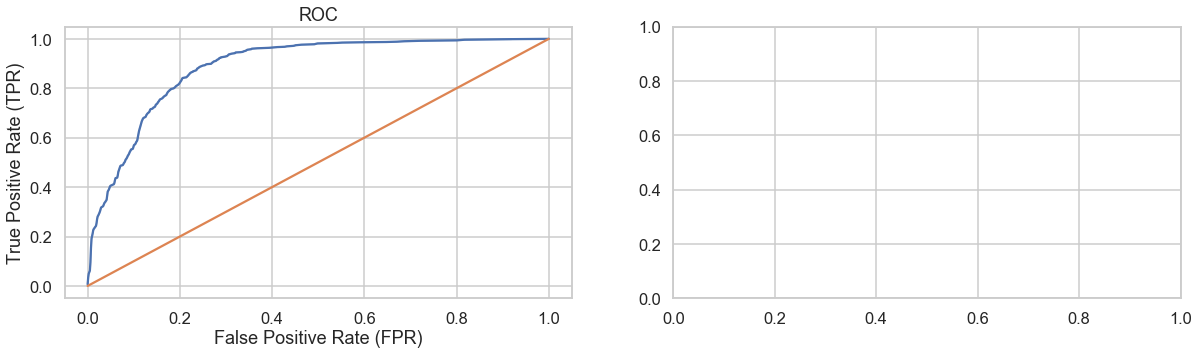

In [629]:
report(grid_search, y_test_gs.replace(yesno), X_test_gs, binary=True)

In [301]:
#nested stratified cross validation
outer_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
nested_score = cross_val_score(grid_search, X=X, y=y, cv=outer_cv)

In [302]:
nested_score

array([0.79744136, 0.79530917, 0.78947368, 0.80654339, 0.81507824])

We could try optimising for recall, using refit parameter in GridSearchCV. The best parameters from GridSearch are refit to maximise scoring.

In [367]:
grid_search_rc = GridSearchCV(pipeline, param_grid=grid_param, cv=inner_cv, refit='recall_score', scoring={'recall_score': make_scorer(recall_score)}) 

In [76]:
yesno = {'Yes':1, 'No':0}
y_train_gs_coded = y_train_gs.replace(yesno)

In [77]:
grid_search_rc.fit(X_train_gs, y_train_gs_coded)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('custom',
                                        <__main__.customTransformer object at 0x1a372b2860>),
                                       ('clfswitcher', ClfSwitcher())]),
             param_grid=[{'clfswitcher__estimator': [XGBClassifier(max_depth=6)],
                          'clfswitcher__estimator__learning_rate': [0.1, 0.15,
                                                                    0.2, 0.25,
                                                                    0.3, 0.35],
                          'clfswitcher__estimator__max_depth': [1, 2, 3, 4, 6,
                                                                7, 8]}],
             refit='recall_score',
             scoring={'recall_score': make_scorer(recall_score)})

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

AUC ROC score: 0.8238620186259842
t: 0.2               precision    recall  f1-score   support

           0       0.91      0.68      0.78      1033
           1       0.48      0.81      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407

t: 0.32000000000000006               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1033
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407

t: 0.44000000000000006               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1033
           1       0.58      0.56      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

{'auc': 0.8238620186259842,
 'mean_scores': [0.02909093,
  0.14332119,
  0.24501908,
  0.3492063,
  0.45222902,
  0.54629964,
  0.647146,
  0.74562836,
  0.8417915,
  0.9158875],
 'n_k': [561, 211, 128, 111, 97, 87, 92, 80, 30, 10],
 'mean_pos': [0.05525846702317291,
  0.1943127962085308,
  0.25,
  0.3963963963963964,
  0.4020618556701031,
  0.4942528735632184,
  0.6195652173913043,
  0.7,
  0.7333333333333333,
  0.9],
 'base_prob': 0.25705737,
 'calib_score': 0.0016026202500264066,
 'ref_score': 0.14441853928734924}

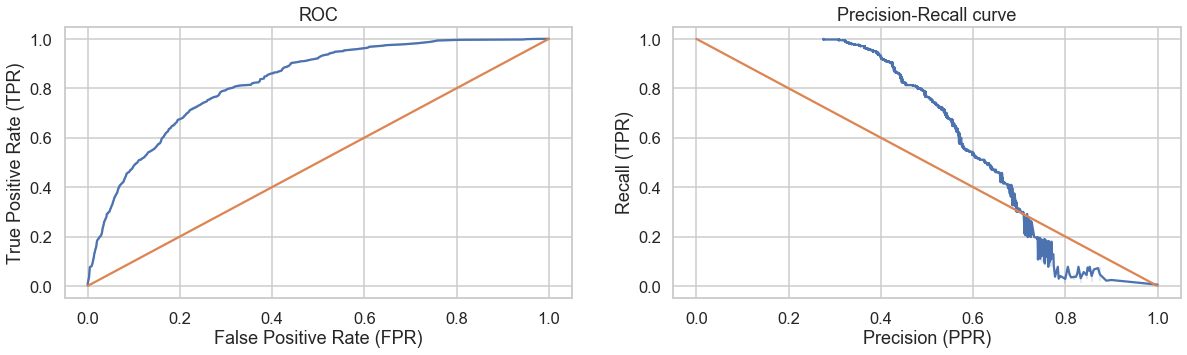

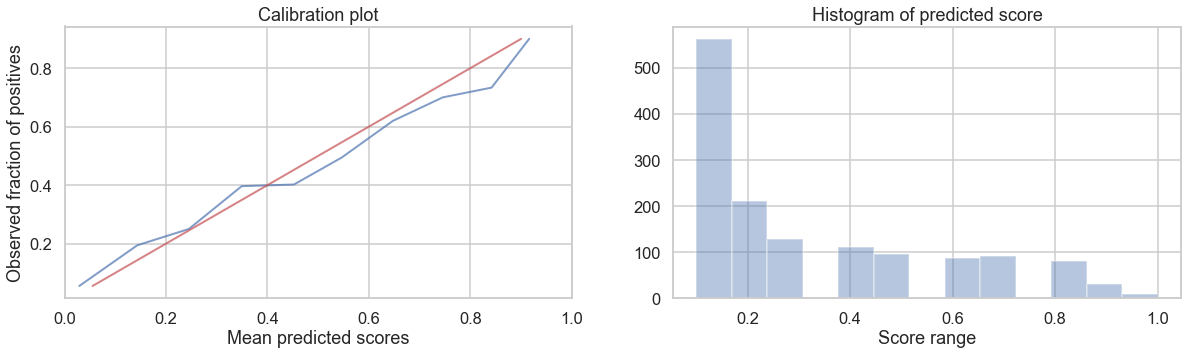

In [87]:
report(grid_search_rc, y_test_gs.replace(yesno), X_test_gs)

## Undersampling

In [481]:
ru = RandomUnderSampler()

In [482]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [483]:
X_us, y_us = ru.fit_resample(X_train,y_train)

In [484]:
inner_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
grid_search_us = GridSearchCV(pipeline, param_grid=grid_param, cv=inner_cv)

In [93]:
#nested stratified cross validation
outer_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
nested_score_us = cross_val_score(grid_search_us, X=X_us, y=y_us, cv=outer_cv)

In [94]:
nested_score_us

array([0.77424749, 0.7458194 , 0.73745819, 0.7909699 , 0.74247492])

In [488]:
grid_search_us.fit(X_train,y_train

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('custom',
                                        <__main__.customTransformer object at 0x1a30ed6da0>),
                                       ('clfswitcher', ClfSwitcher())]),
             param_grid=[{'clfswitcher__estimator': [XGBClassifier(learning_rate=0.2,
                                                                   max_depth=1)],
                          'clfswitcher__estimator__learning_rate': [0.1, 0.15,
                                                                    0.2, 0.25,
                                                                    0.3, 0.35],
                          'clfswitcher__estimator__max_depth': [1, 2, 3, 4, 6,
                                                                7, 8, 9]}])

In [489]:
grid_search_us.best_estimator_

Pipeline(steps=[('custom', <__main__.customTransformer object at 0x1a2a3f7f98>),
                ('clfswitcher',
                 ClfSwitcher(estimator=XGBClassifier(learning_rate=0.2,
                                                     max_depth=1)))])

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1033
         Yes       0.64      0.45      0.53       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.78      1407



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



AUC ROC score: 0.8347720413519628
t: 0.2               precision    recall  f1-score   support

           0       0.91      0.64      0.75      1033
           1       0.45      0.82      0.58       374

    accuracy                           0.69      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.79      0.69      0.71      1407

t: 0.32000000000000006               precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.53      0.74      0.61       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.75      0.76      1407

t: 0.44000000000000006               precision    recall  f1-score   support

           0       0.86      0.87      0.87      1033
           1       0.63      0.60      0.62       374

    accuracy                           0.80      1407
   macro avg       0.75      0.74      0.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/le

{'auc': 0.8347720413519628,
 'mean_scores': [0.037142184,
  0.1531539,
  0.25354362,
  0.3516602,
  0.45148447,
  0.55168724,
  0.63847053,
  0.74194,
  0.81855786],
 'n_k': [520, 208, 130, 139, 146, 110, 110, 39, 5],
 'mean_pos': [0.04230769230769231,
  0.21634615384615385,
  0.17692307692307693,
  0.2805755395683453,
  0.5136986301369864,
  0.5545454545454546,
  0.6363636363636364,
  0.8974358974358975,
  0.8],
 'base_prob': 0.25790614,
 'calib_score': 0.0027158724043616694,
 'ref_score': 0.1398803099434968}

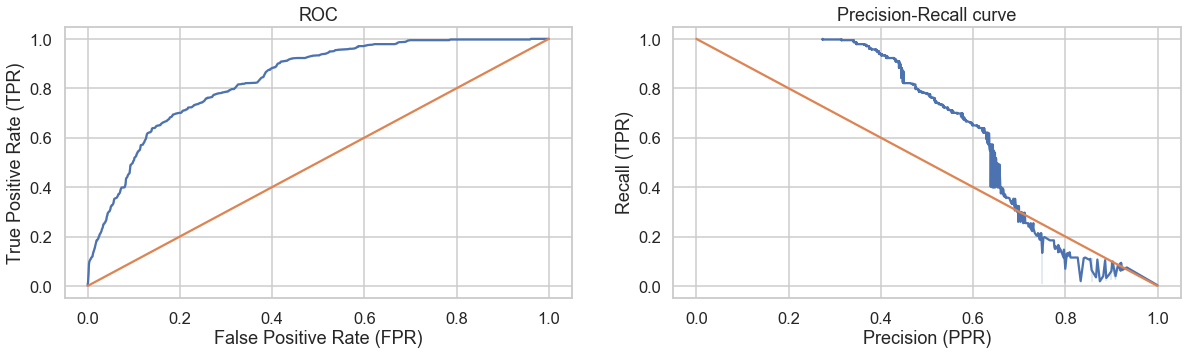

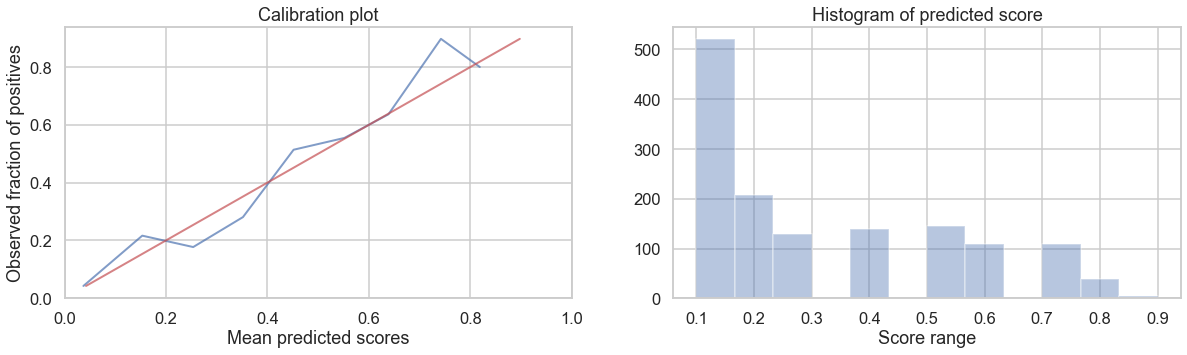

In [491]:
report(grid_search_us, y_test.replace(yesno), X_test, binary=True)

### Optimising for 'recall'

In [100]:
grid_search_us_rc = GridSearchCV(pipeline, param_grid=grid_param, cv=inner_cv, refit='recall_score', scoring={'recall_score': make_scorer(recall_score)}) 

In [102]:
grid_search_us_rc.fit(X_train, y_train.replace(yesno))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('custom',
                                        <__main__.customTransformer object at 0x1a372b2860>),
                                       ('clfswitcher', ClfSwitcher())]),
             param_grid=[{'clfswitcher__estimator': [XGBClassifier(max_depth=6)],
                          'clfswitcher__estimator__learning_rate': [0.1, 0.15,
                                                                    0.2, 0.25,
                                                                    0.3, 0.35],
                          'clfswitcher__estimator__max_depth': [1, 2, 3, 4, 6,
                                                                7, 8]}],
             refit='recall_score',
             scoring={'recall_score': make_scorer(recall_score)})

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

AUC ROC score: 0.8238620186259842
t: 0.2               precision    recall  f1-score   support

           0       0.91      0.68      0.78      1033
           1       0.48      0.81      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407

t: 0.32000000000000006               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1033
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407

t: 0.44000000000000006               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1033
           1       0.58      0.56      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

{'auc': 0.8238620186259842,
 'mean_scores': [0.02909093,
  0.14332119,
  0.24501908,
  0.3492063,
  0.45222902,
  0.54629964,
  0.647146,
  0.74562836,
  0.8417915,
  0.9158875],
 'n_k': [561, 211, 128, 111, 97, 87, 92, 80, 30, 10],
 'mean_pos': [0.05525846702317291,
  0.1943127962085308,
  0.25,
  0.3963963963963964,
  0.4020618556701031,
  0.4942528735632184,
  0.6195652173913043,
  0.7,
  0.7333333333333333,
  0.9],
 'base_prob': 0.25705737,
 'calib_score': 0.0016026202500264066,
 'ref_score': 0.14441853928734924}

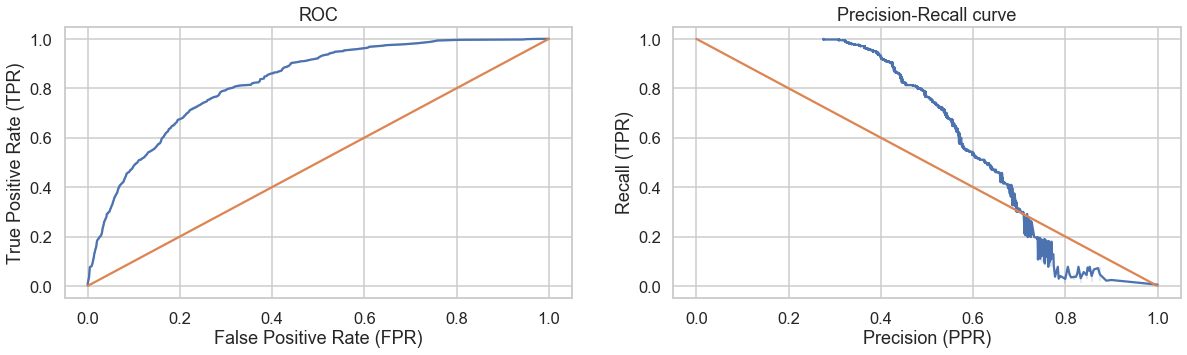

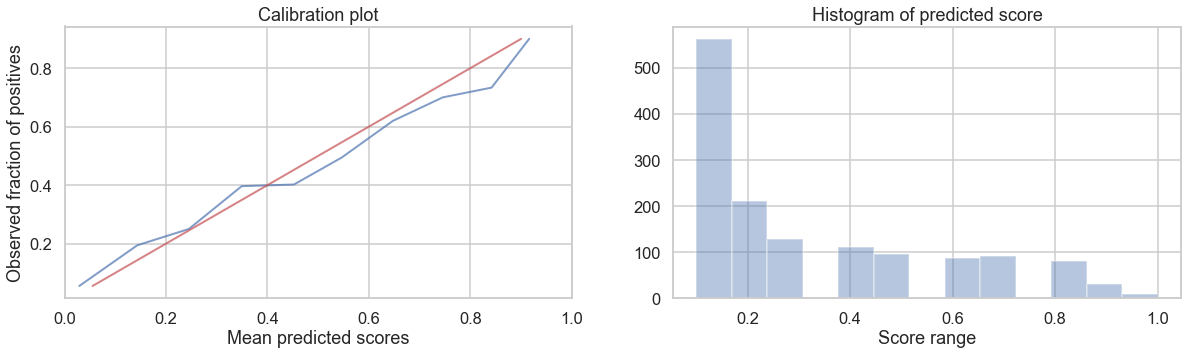

In [116]:
report(grid_search_us_rc, y_test, X_test)

## Oversampling

In [46]:
ro = RandomOverSampler()

In [773]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
X_os, y_os = ro.fit_resample(X_train,y_train)

In [477]:
grid_search_os = GridSearchCV(pipeline, param_grid=grid_param, cv=inner_cv)

In [122]:
#nested stratified cross validation
outer_cv = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
nested_score_os = cross_val_score(grid_search_os, X=X_os, y=y_os, cv=outer_cv)

In [123]:
nested_score_os

array([0.83716707, 0.80992736, 0.8311138 , 0.82687651, 0.8153753 ])

In [478]:
grid_search_os.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('custom',
                                        <__main__.customTransformer object at 0x1a30ed6da0>),
                                       ('clfswitcher', ClfSwitcher())]),
             param_grid=[{'clfswitcher__estimator': [XGBClassifier(learning_rate=0.2,
                                                                   max_depth=1)],
                          'clfswitcher__estimator__learning_rate': [0.1, 0.15,
                                                                    0.2, 0.25,
                                                                    0.3, 0.35],
                          'clfswitcher__estimator__max_depth': [1, 2, 3, 4, 6,
                                                                7, 8, 9]}])

In [479]:
grid_search_os.best_estimator_

Pipeline(steps=[('custom', <__main__.customTransformer object at 0x1a2afe7390>),
                ('clfswitcher',
                 ClfSwitcher(estimator=XGBClassifier(learning_rate=0.2,
                                                     max_depth=1)))])

              precision    recall  f1-score   support

          No       0.82      0.91      0.86      1033
         Yes       0.64      0.45      0.53       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.78      1407



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



AUC ROC score: 0.8347720413519628
t: 0.2               precision    recall  f1-score   support

           0       0.91      0.64      0.75      1033
           1       0.45      0.82      0.58       374

    accuracy                           0.69      1407
   macro avg       0.68      0.73      0.67      1407
weighted avg       0.79      0.69      0.71      1407

t: 0.32000000000000006               precision    recall  f1-score   support

           0       0.89      0.76      0.82      1033
           1       0.53      0.74      0.61       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.72      1407
weighted avg       0.79      0.75      0.76      1407

t: 0.44000000000000006               precision    recall  f1-score   support

           0       0.86      0.87      0.87      1033
           1       0.63      0.60      0.62       374

    accuracy                           0.80      1407
   macro avg       0.75      0.74      0.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/opt/anaconda3/envs/le

{'auc': 0.8347720413519628,
 'mean_scores': [0.037142184,
  0.1531539,
  0.25354362,
  0.3516602,
  0.45148447,
  0.55168724,
  0.63847053,
  0.74194,
  0.81855786],
 'n_k': [520, 208, 130, 139, 146, 110, 110, 39, 5],
 'mean_pos': [0.04230769230769231,
  0.21634615384615385,
  0.17692307692307693,
  0.2805755395683453,
  0.5136986301369864,
  0.5545454545454546,
  0.6363636363636364,
  0.8974358974358975,
  0.8],
 'base_prob': 0.25790614,
 'calib_score': 0.0027158724043616694,
 'ref_score': 0.1398803099434968}

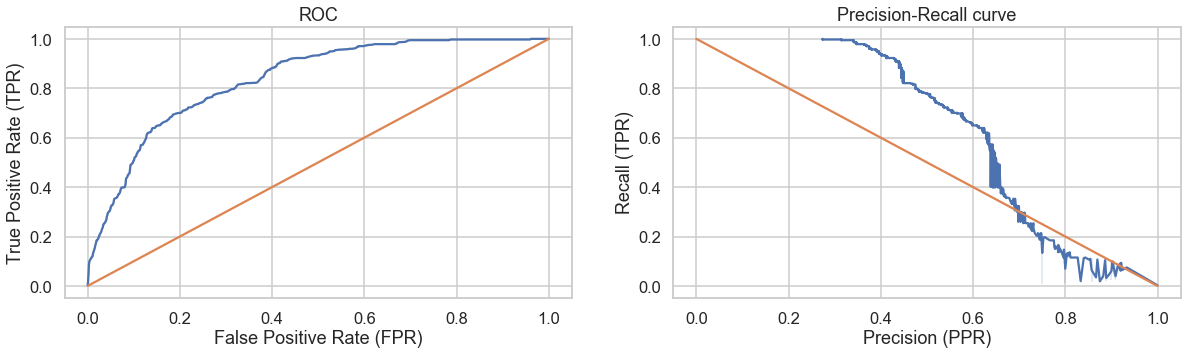

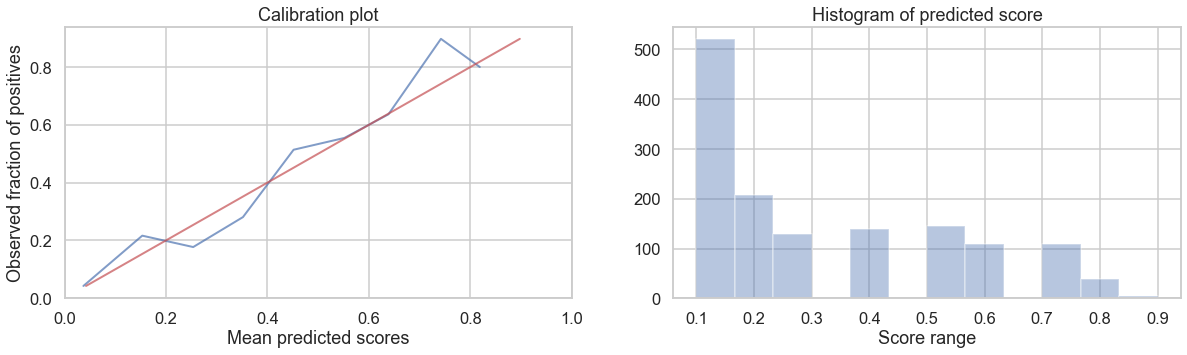

In [480]:
report(grid_search_os, y_test, X_test)

### Optimising for 'recall'

In [775]:
grid_search_rc_os = GridSearchCV(pipeline, param_grid=grid_param, cv=inner_cv, scoring='recall') 

In [776]:
grid_search_rc_os.fit(X_train, y_train.replace(yesno))

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('custom',
                                        <__main__.customTransformer object at 0x1a30ed6da0>),
                                       ('clfswitcher', ClfSwitcher())]),
             param_grid=[{'clfswitcher__estimator': [XGBClassifier(learning_rate=0.25,
                                                                   max_depth=4)],
                          'clfswitcher__estimator__learning_rate': [0.1, 0.15,
                                                                    0.2, 0.25,
                                                                    0.3, 0.35],
                          'clfswitcher__estimator__max_depth': [1, 2, 3, 4, 6,
                                                                7, 8, 9]}],
             scoring='recall')

In [778]:
grid_search_rc_os.best_estimator_

Pipeline(steps=[('custom', <__main__.customTransformer object at 0x1a43e1d390>),
                ('clfswitcher',
                 ClfSwitcher(estimator=XGBClassifier(learning_rate=0.25,
                                                     max_depth=4)))])

              precision    recall  f1-score   support

          No       0.83      0.89      0.86      1033
         Yes       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

AUC ROC score: 0.8238620186259842
t: 0.2               precision    recall  f1-score   support

           0       0.91      0.68      0.78      1033
           1       0.48      0.81      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.74      0.69      1407
weighted avg       0.79      0.71      0.73      1407

t: 0.32000000000000006               precision    recall  f1-score   support

           0       0.88      0.78      0.83      1033
           1       0.54      0.70      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407

t: 0.44000000000000006               precision    recall  f1-score   support

           0       0.84      0.85      0.85      1033
           1       0.58      0.56      0.57       374

    accuracy                           0.77      1407
   macro avg       0.71      0.71      0.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

{'auc': 0.8238620186259842,
 'mean_scores': [0.02909093,
  0.14332119,
  0.24501908,
  0.3492063,
  0.45222902,
  0.54629964,
  0.647146,
  0.74562836,
  0.8417915,
  0.9158875],
 'n_k': [561, 211, 128, 111, 97, 87, 92, 80, 30, 10],
 'mean_pos': [0.05525846702317291,
  0.1943127962085308,
  0.25,
  0.3963963963963964,
  0.4020618556701031,
  0.4942528735632184,
  0.6195652173913043,
  0.7,
  0.7333333333333333,
  0.9],
 'base_prob': 0.25705737,
 'calib_score': 0.0016026202500264066,
 'ref_score': 0.14441853928734924}

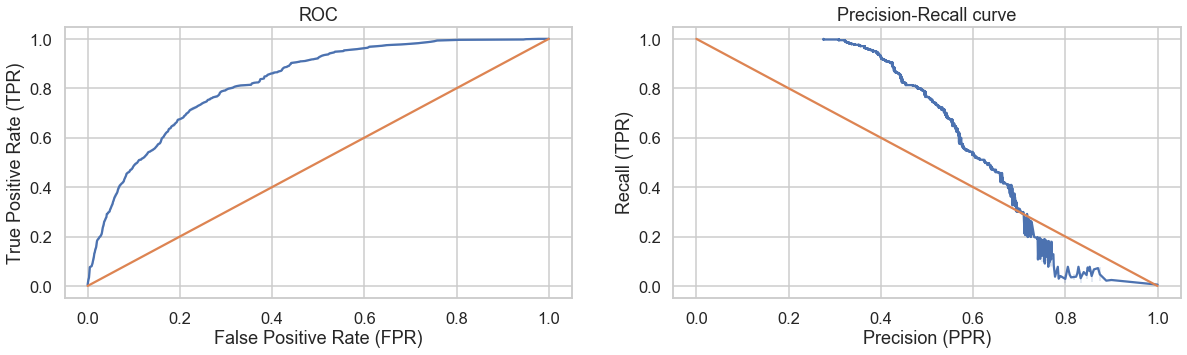

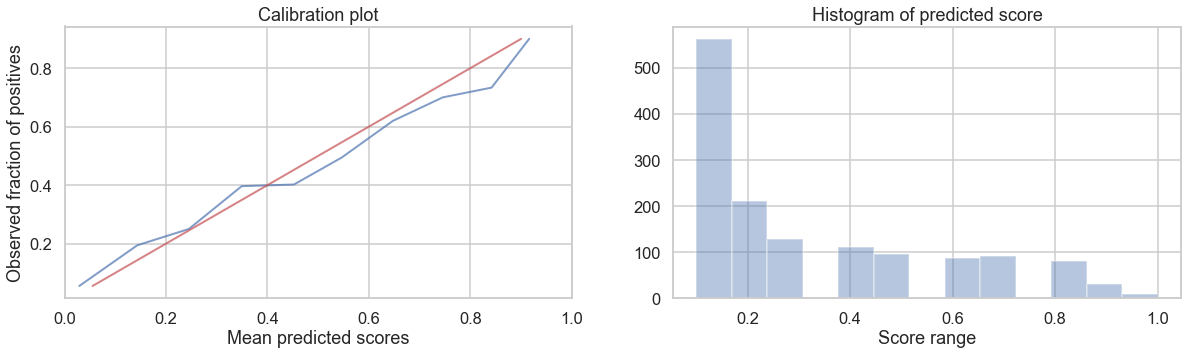

In [178]:
report(grid_search_rc_os, y_test.replace(yesno), X_test, binary=True)

## Risk levels

Briefly, the idea is:
1. We obtained the best model:
    - Pre-processed data with RandomOversampling
    - XGBoost classifier with hyperparameters optimised with GridSearch for 'recall'
    
    
2. This model has been used to asses risk levels of the current customers base


3. Risk levels have been defined as:
    - Low-medium risk: predicted probability < 0.7
    - High risk: 0.7 < predicted probability < 0.9
    - Very high risk: predicted probability > 0.9
    
    
4. To reduce churn rate, we considered retention campaigns. We want to know:
         4.1. Who to target
         4.2. Estimated financials (costs, revenues, profits, ROI) for different classification thresholds and conversion rates
         4.3. Optimal threshold value to use to decide the minimum predicted probability to label customers as churned or not
        4.4. Optimal range of conversion rates for KPI setting

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_os,y_os,test_size=.2, random_state=42, stratify=y_os)
X_test_sd = X_test.copy(deep=True)
X_test_sd[numeric] = StandardScaler().fit_transform(X_test[numeric])
X_test_sd = pd.get_dummies(X_test_sd, drop_first=True)
X_train_sd = X_train.copy(deep=True)
X_train_sd[numeric] = StandardScaler().fit_transform(X_train[numeric])
X_train_sd = pd.get_dummies(X_train_sd, drop_first=True)
X_train_sd = X_train_sd.drop(to_drop, axis=1)
X_test_sd = X_test_sd.drop(to_drop, axis=1)
d_train = xgb.DMatrix(X_train_sd, label=y_train.replace(yesno))
d_test = xgb.DMatrix(X_test_sd, label=y_test.replace(yesno))

In [724]:
xgb.cv(params={'objective':'binary:logistic', 'max_depth':4, 'learning_rate':0.25}, dtrain=d_train, nfold=10, stratified=True, metrics='error')

train-error-mean  train-error-std  test-error-mean  test-error-std
0          0.169710         0.004104         0.213071        0.013950
1          0.148624         0.003587         0.194004        0.010270
2          0.137141         0.003340         0.187497        0.014118
3          0.129237         0.002083         0.181900        0.012705
4          0.123621         0.002472         0.177361        0.011048
5          0.117618         0.002182         0.175089        0.010741
6          0.111716         0.003431         0.171759        0.011580
7          0.107076         0.003836         0.171307        0.009538
8          0.102737         0.003249         0.169491        0.010237
9          0.099711         0.003135         0.166163        0.009459

In [451]:
xgbclassifier = xgb.XGBClassifier(max_depth=4, learning_rate=0.25)

In [452]:
xgbclassifier.fit(X_train_sd, y_train.replace(yesno))

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


XGBClassifier(learning_rate=0.25, max_depth=4)

In [453]:
xgbclassifier.score(X_test_sd, y_test.replace(yesno))

0.7935835351089588

In [461]:
xgbclassifier.score(X_rl_sd, y_reset.replace(yesno))

0.751848691695108

              precision    recall  f1-score   support

          No       0.81      0.76      0.79       826
         Yes       0.78      0.83      0.80       826

    accuracy                           0.79      1652
   macro avg       0.79      0.79      0.79      1652
weighted avg       0.79      0.79      0.79      1652



/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


AUC ROC score: 0.8660270916755096
t: 0.2               precision    recall  f1-score   support

           0       0.91      0.50      0.65       826
           1       0.66      0.95      0.78       826

    accuracy                           0.73      1652
   macro avg       0.78      0.73      0.71      1652
weighted avg       0.78      0.73      0.71      1652

t: 0.32000000000000006               precision    recall  f1-score   support

           0       0.88      0.62      0.73       826
           1       0.71      0.91      0.80       826

    accuracy                           0.77      1652
   macro avg       0.79      0.77      0.76      1652
weighted avg       0.79      0.77      0.76      1652

t: 0.44000000000000006               precision    recall  f1-score   support

           0       0.84      0.73      0.78       826
           1       0.76      0.86      0.81       826

    accuracy                           0.79      1652
   macro avg       0.80      0.79      0.

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretati

{'auc': 0.8660270916755096,
 'mean_scores': [0.031549126,
  0.14988762,
  0.24824372,
  0.35211578,
  0.449549,
  0.55183613,
  0.65436727,
  0.7569243,
  0.85481447,
  0.93762535],
 'n_k': [329, 124, 114, 106, 98, 110, 179, 190, 225, 177],
 'mean_pos': [0.0486322188449848,
  0.1935483870967742,
  0.21052631578947367,
  0.33962264150943394,
  0.4387755102040816,
  0.6363636363636364,
  0.6703910614525139,
  0.7631578947368421,
  0.7911111111111111,
  0.96045197740113],
 'base_prob': 0.49551326,
 'calib_score': 0.0014328513972927724,
 'ref_score': 0.14811467252029478}

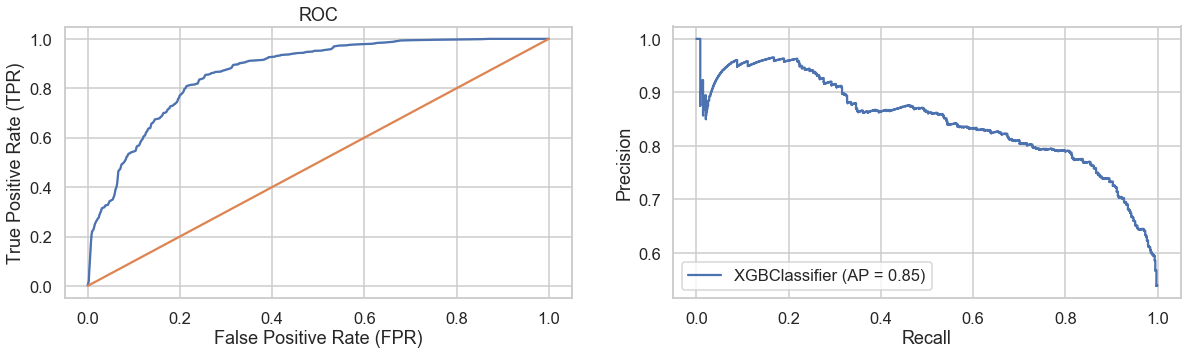

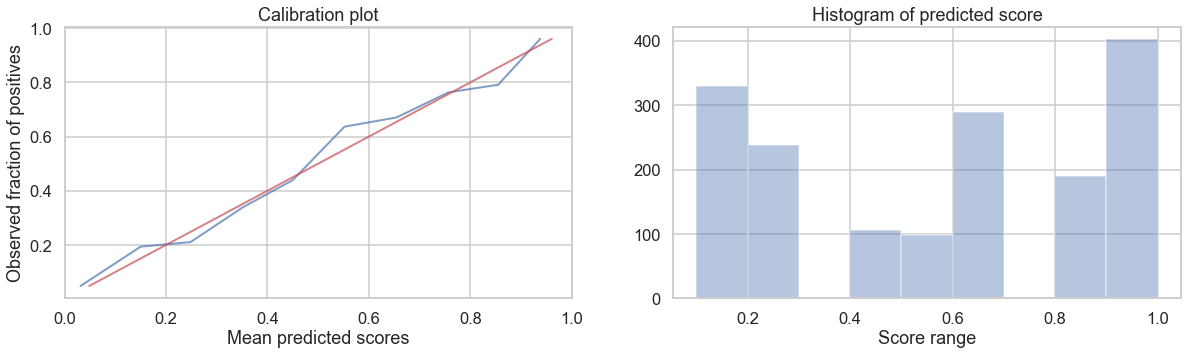

In [486]:
report(xgbclassifier, y_test.replace(yesno), X_test_sd, binary=True)

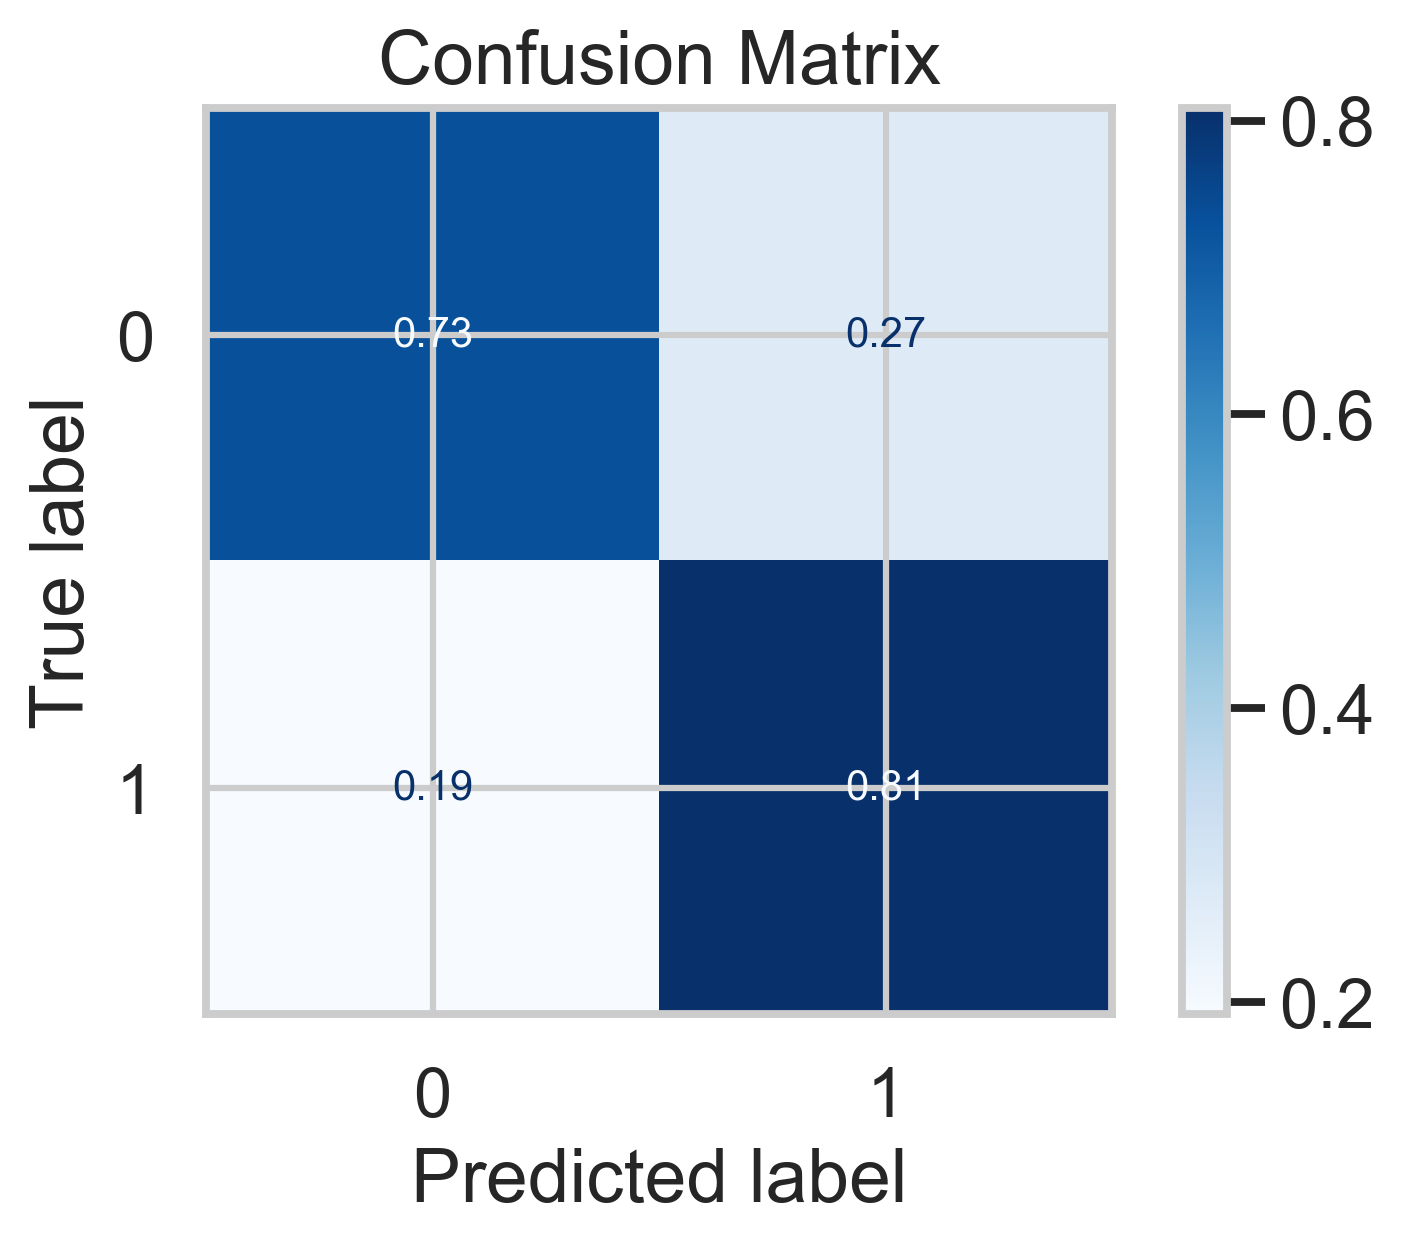

In [527]:
confusionMatrix(xgbclassifier, X_rl_sd, y, save=True)

Obtaining financials for campaigning for customers with churn risk classified as "high" or "very high".

In [592]:
thrs = np.linspace(0,1,10)
df_risk, X_rl_sd, profs, revs, costs = churnSegments(X, y, xgbclassifier, thrs, CAC, conv_rate, numeric, to_drop)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:41: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike


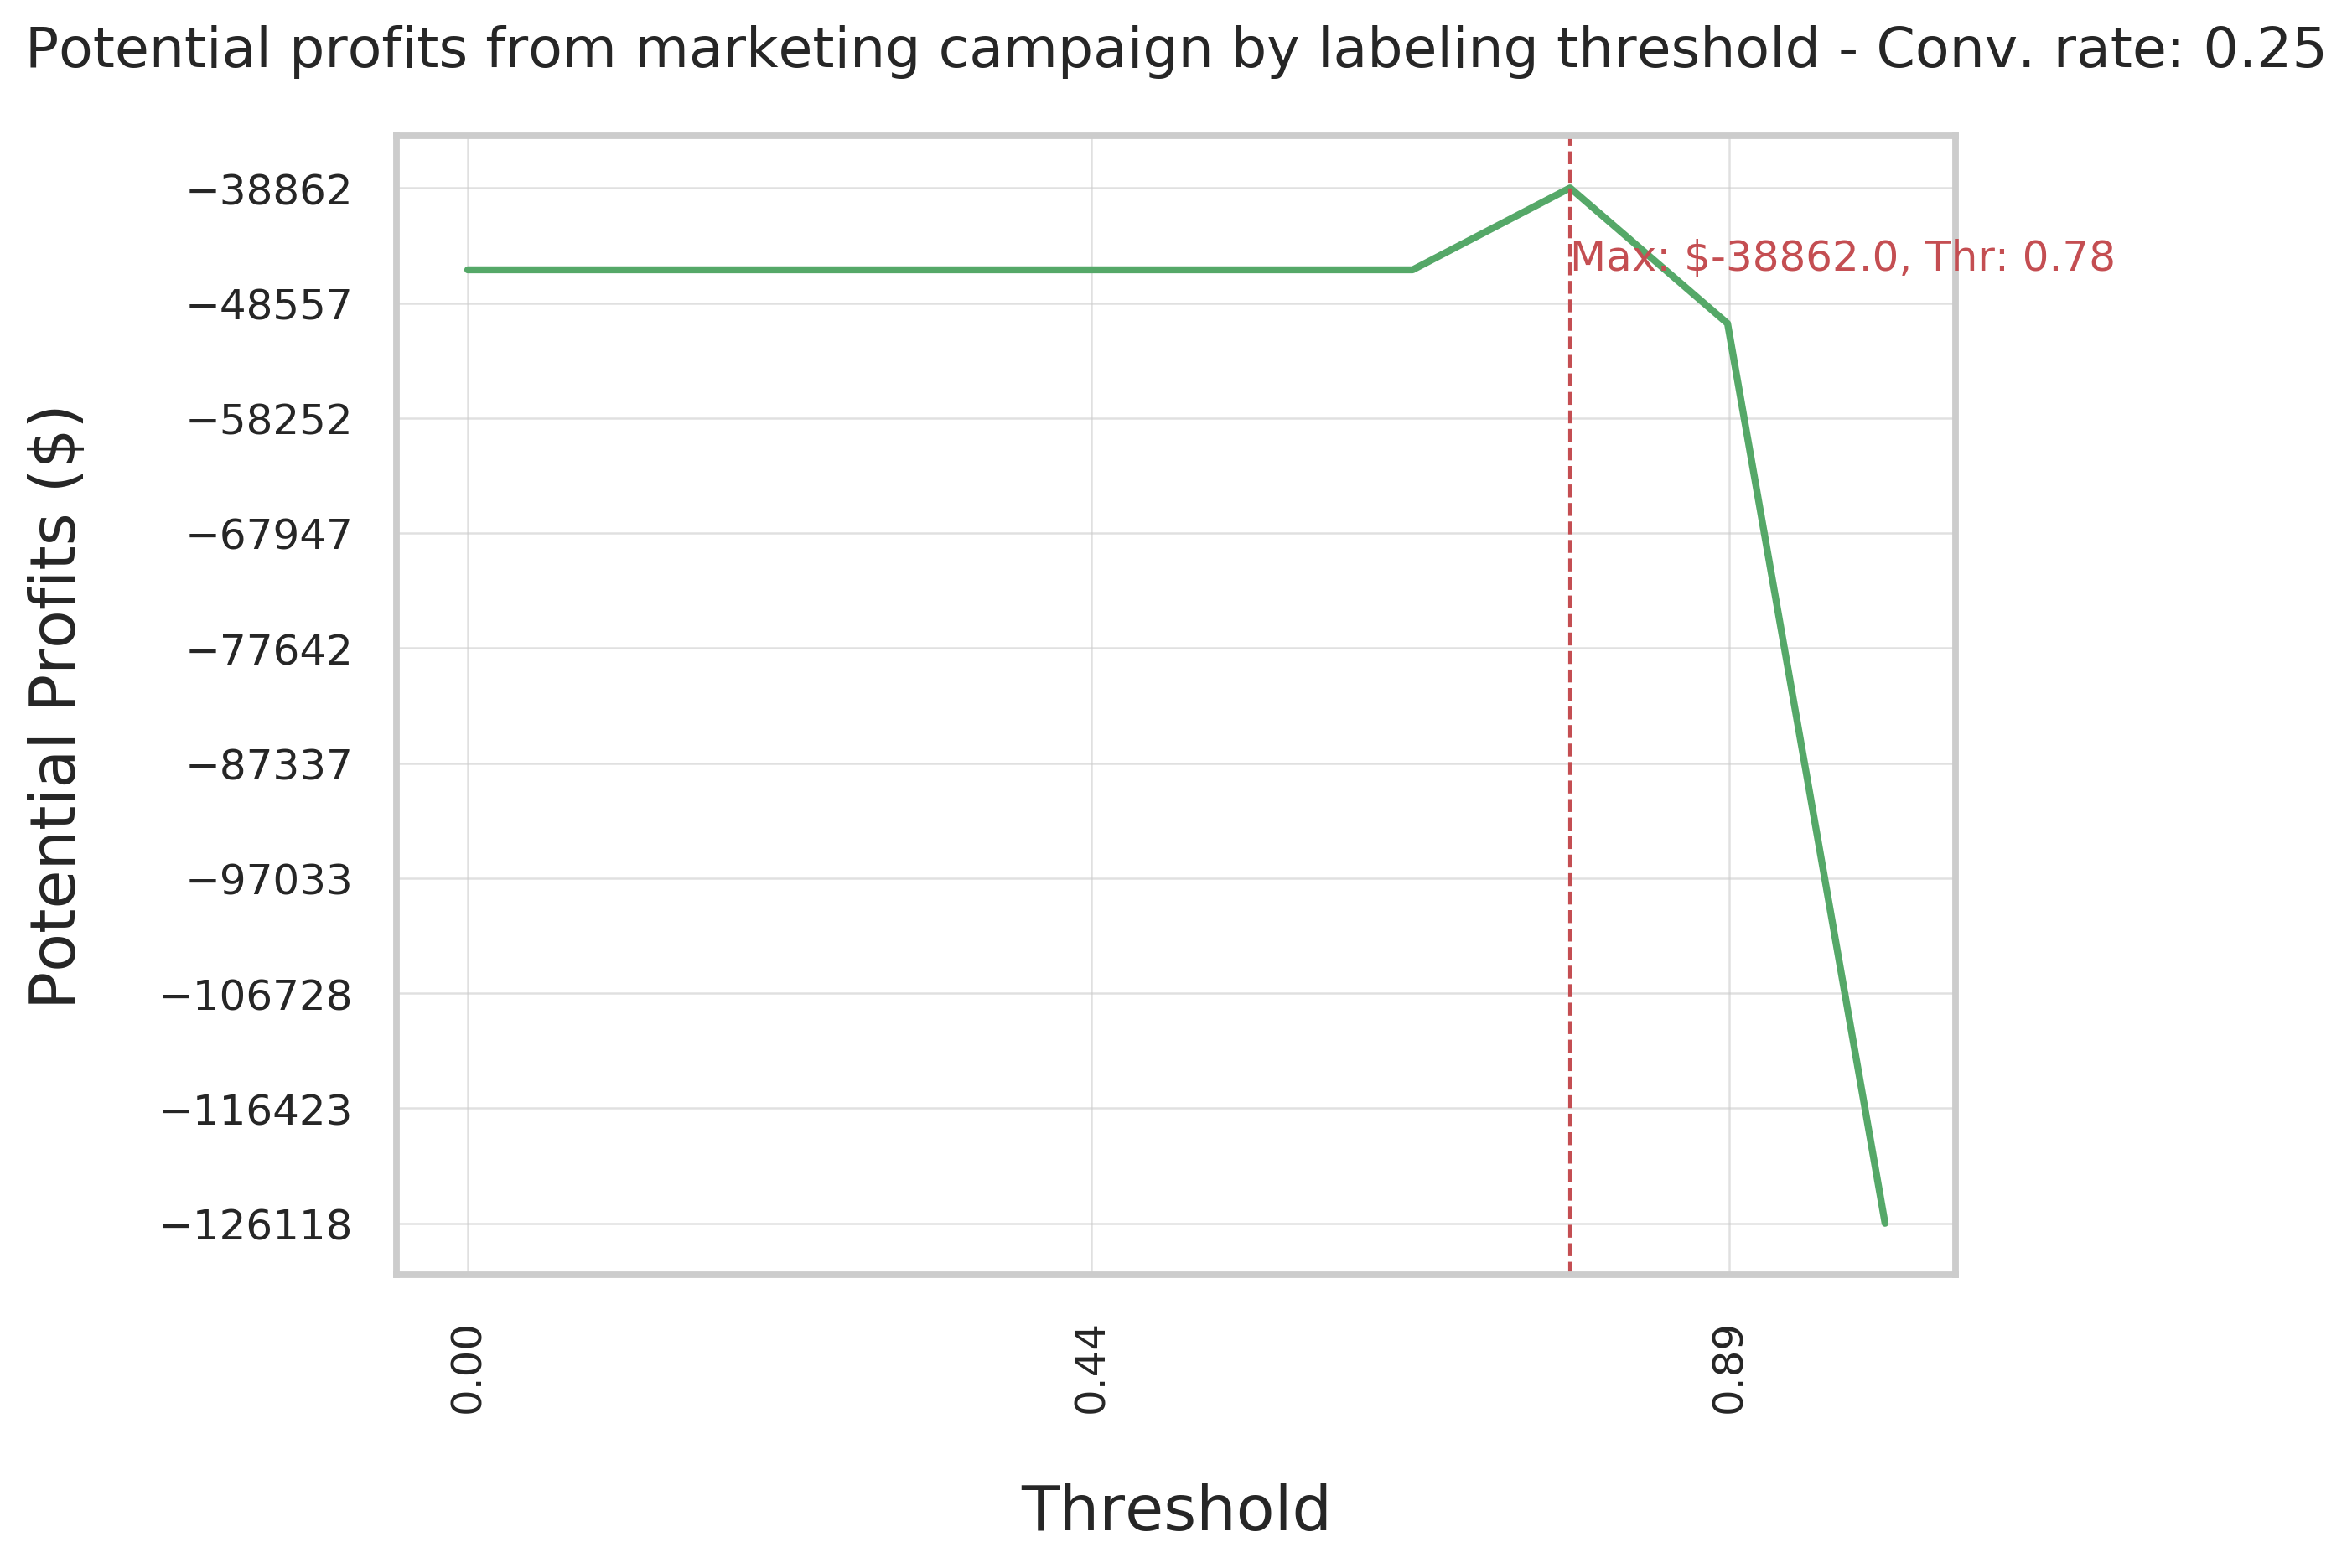

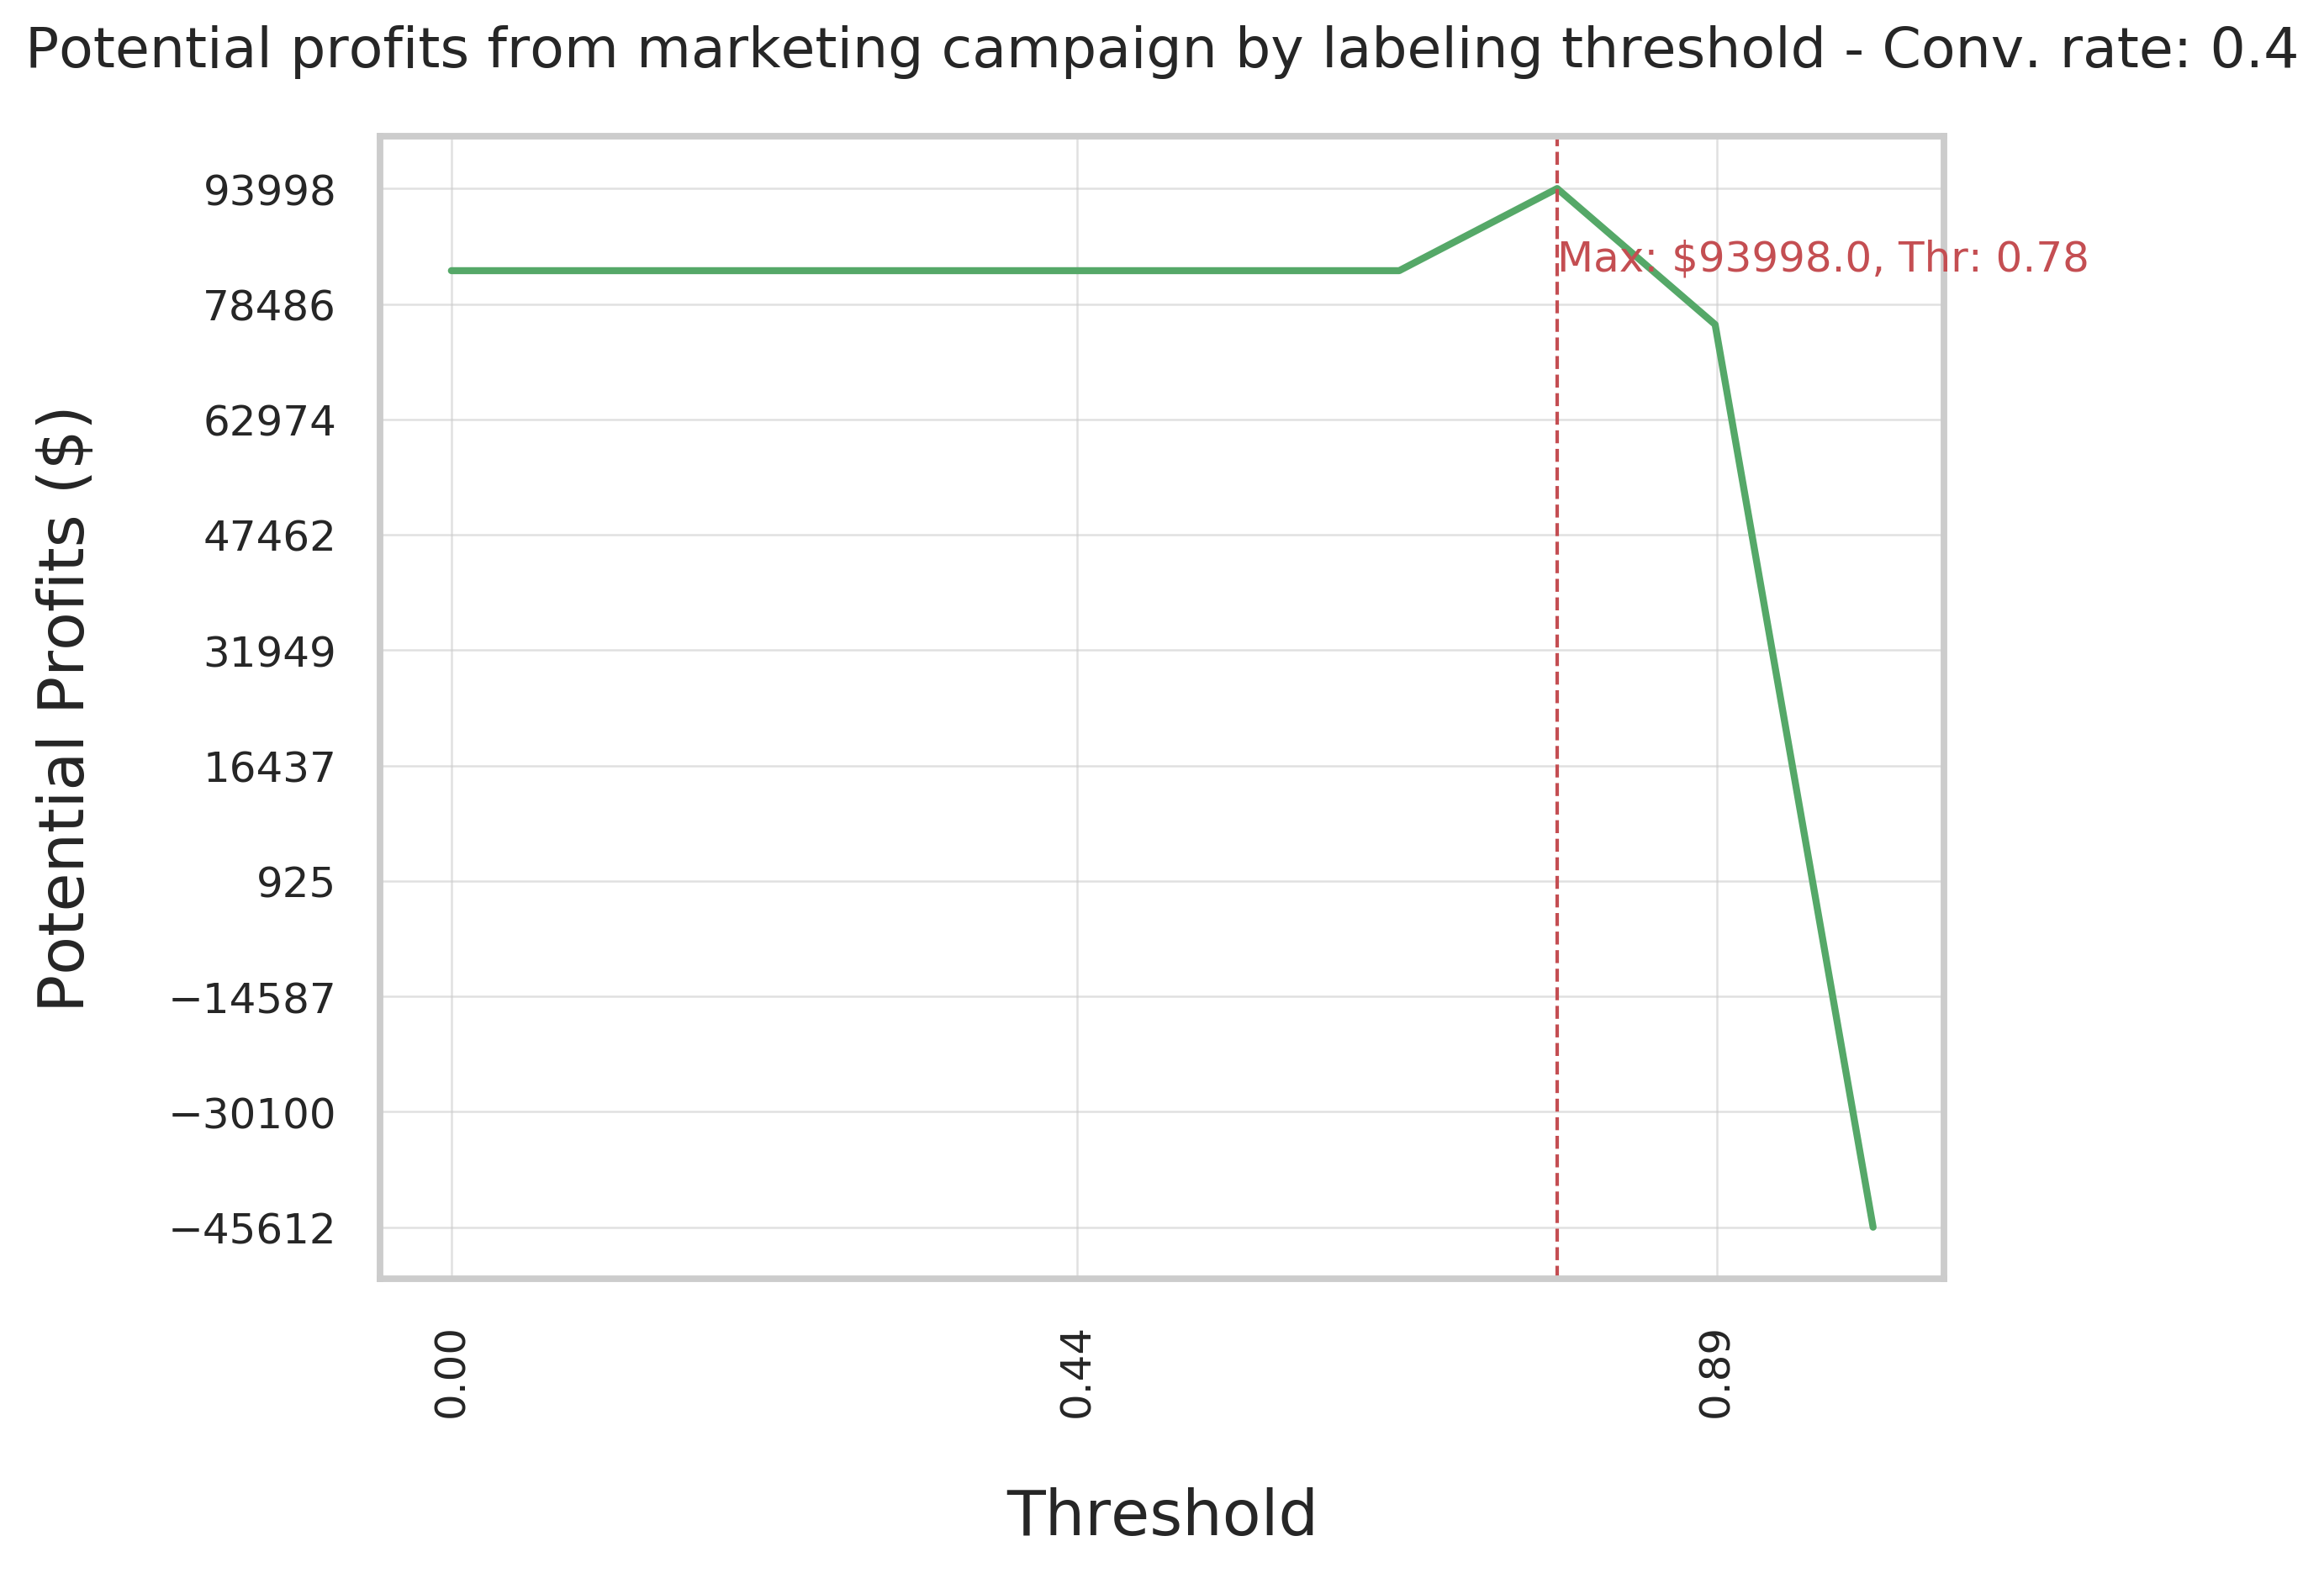

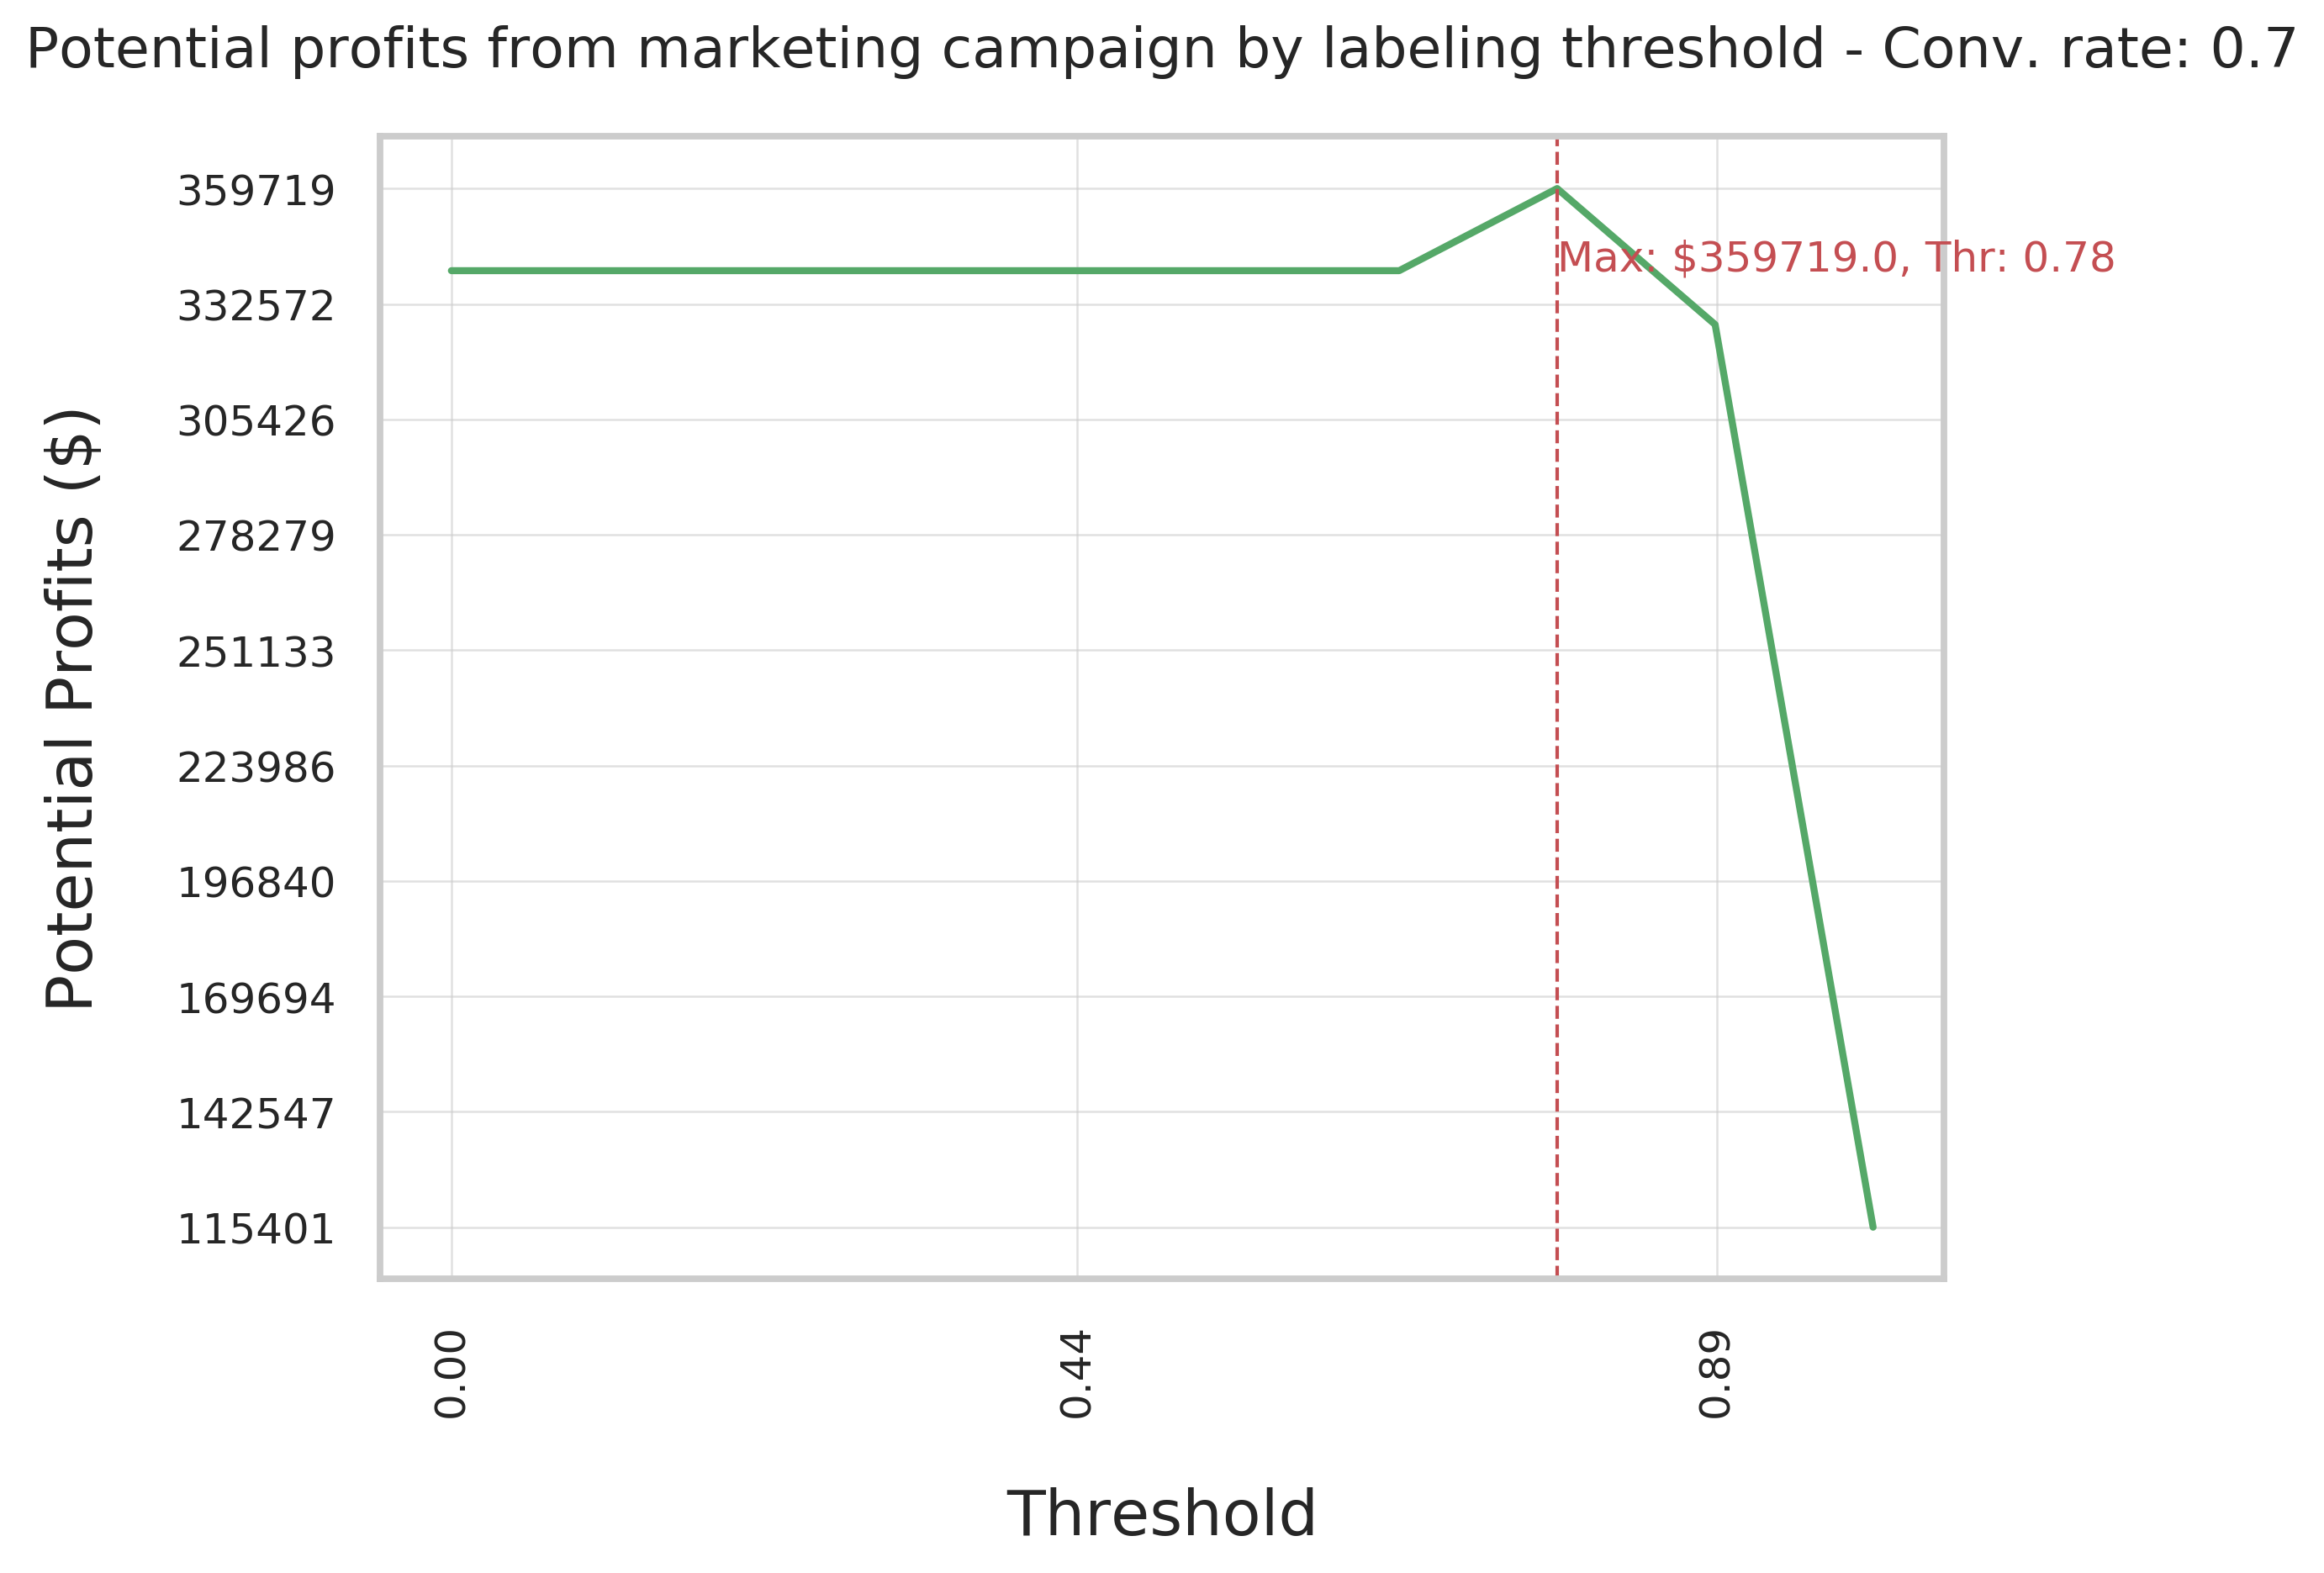

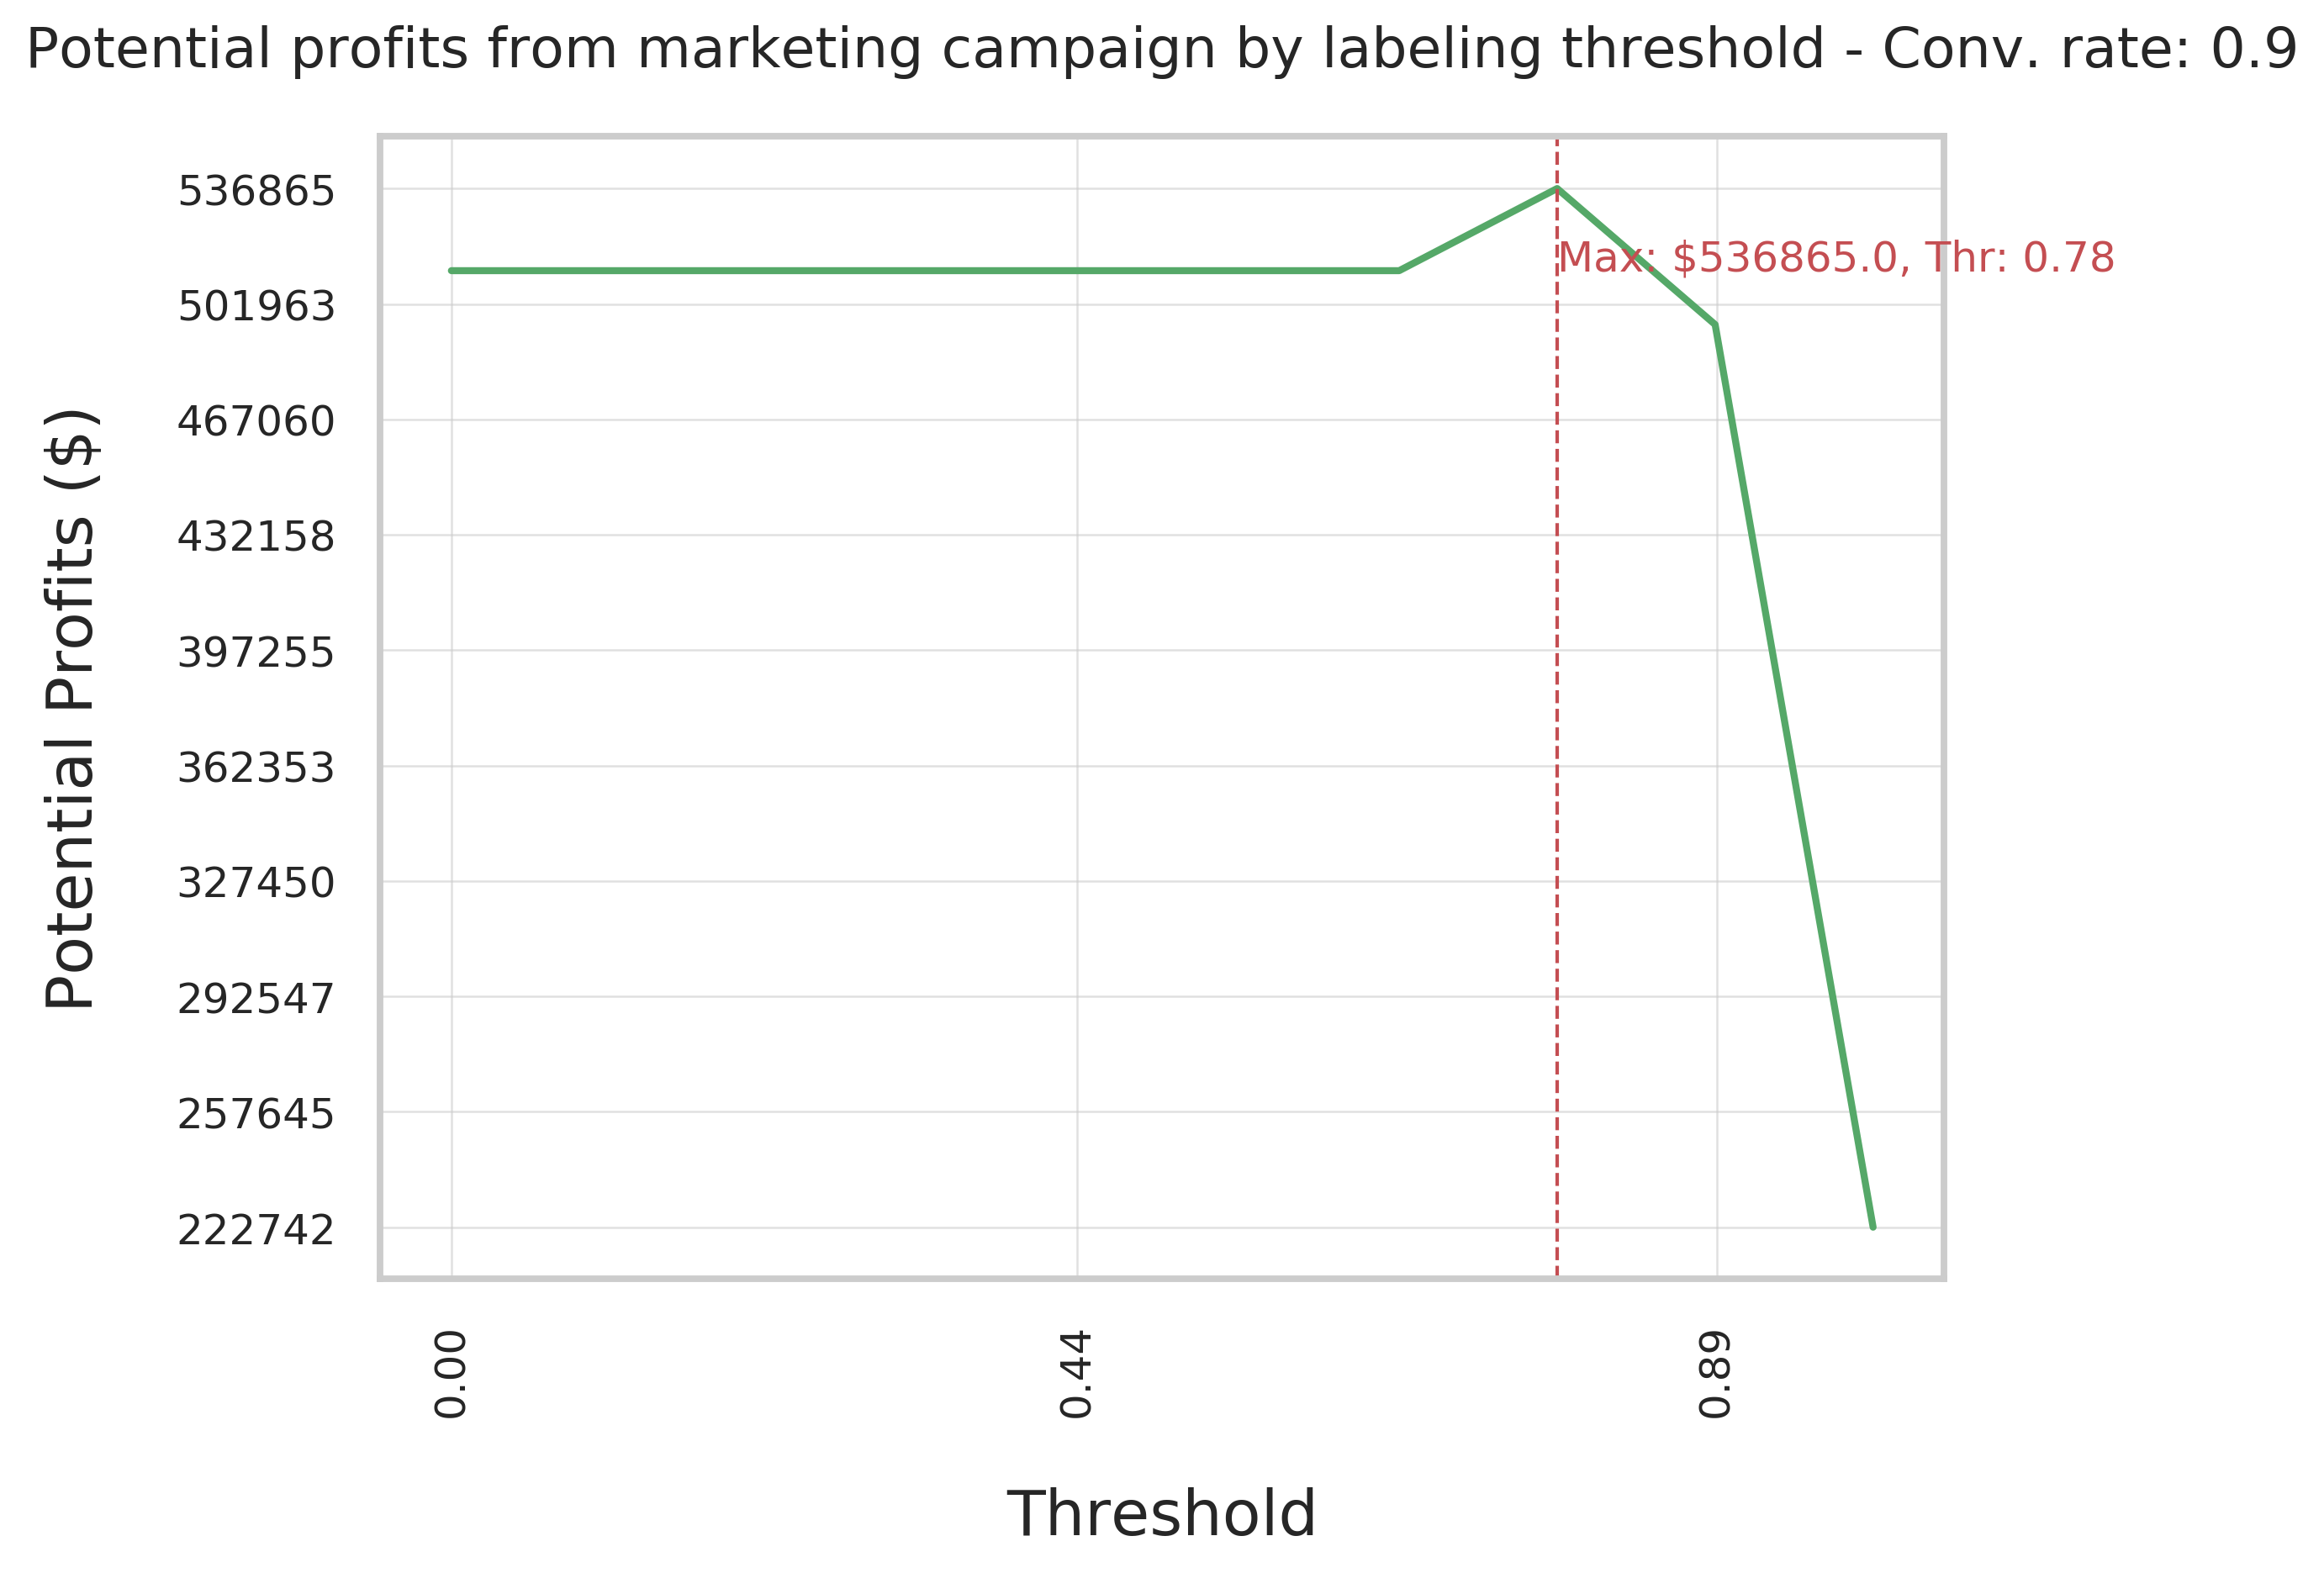

In [595]:
for conv_rate in profs.keys():
    index_max = [i for i,j in enumerate(profs[conv_rate]) if j == np.max(profs[conv_rate])]
    title = 'Potential profits from marketing campaign by labeling threshold - Conv. rate: {}'.format(conv_rate)

    plt.figure(figsize=(8,6), dpi=300)
    sns.lineplot(x=thrs, y=profs[conv_rate], color='g')
    plt.axvline(thrs[index_max], linestyle='--', linewidth=1, color='r')
    plt.text(thrs[index_max], profs[conv_rate][0], 'Max: ${}, Thr: {}'.format(np.round(np.max(profs[conv_rate]), 0), np.round(thrs[index_max][0], 2)), fontsize=12,
                   rotation=0, rotation_mode='anchor', color='r', fontdict=fonttitle)

    fonttitle = {'fontname': 'Quicksand'}
    plt.title(title, pad=20, **fonttitle, fontsize=16)
    plt.xticks(ticks=np.round(thrs[::4],2), rotation=90, **fonttitle, fontsize=12);
    plt.yticks(ticks=np.linspace(np.min(profs[conv_rate]),np.max(profs[conv_rate]), 10), **fonttitle, fontsize=12);
    plt.xlabel('Threshold', labelpad=20, **fonttitle)
    plt.ylabel('Potential Profits ($)', labelpad=20, **fonttitle);
    plt.grid(alpha=0.6, linewidth=0.6)

    plt.savefig('./images/{}.png'.format(title), bbox_inches = "tight")

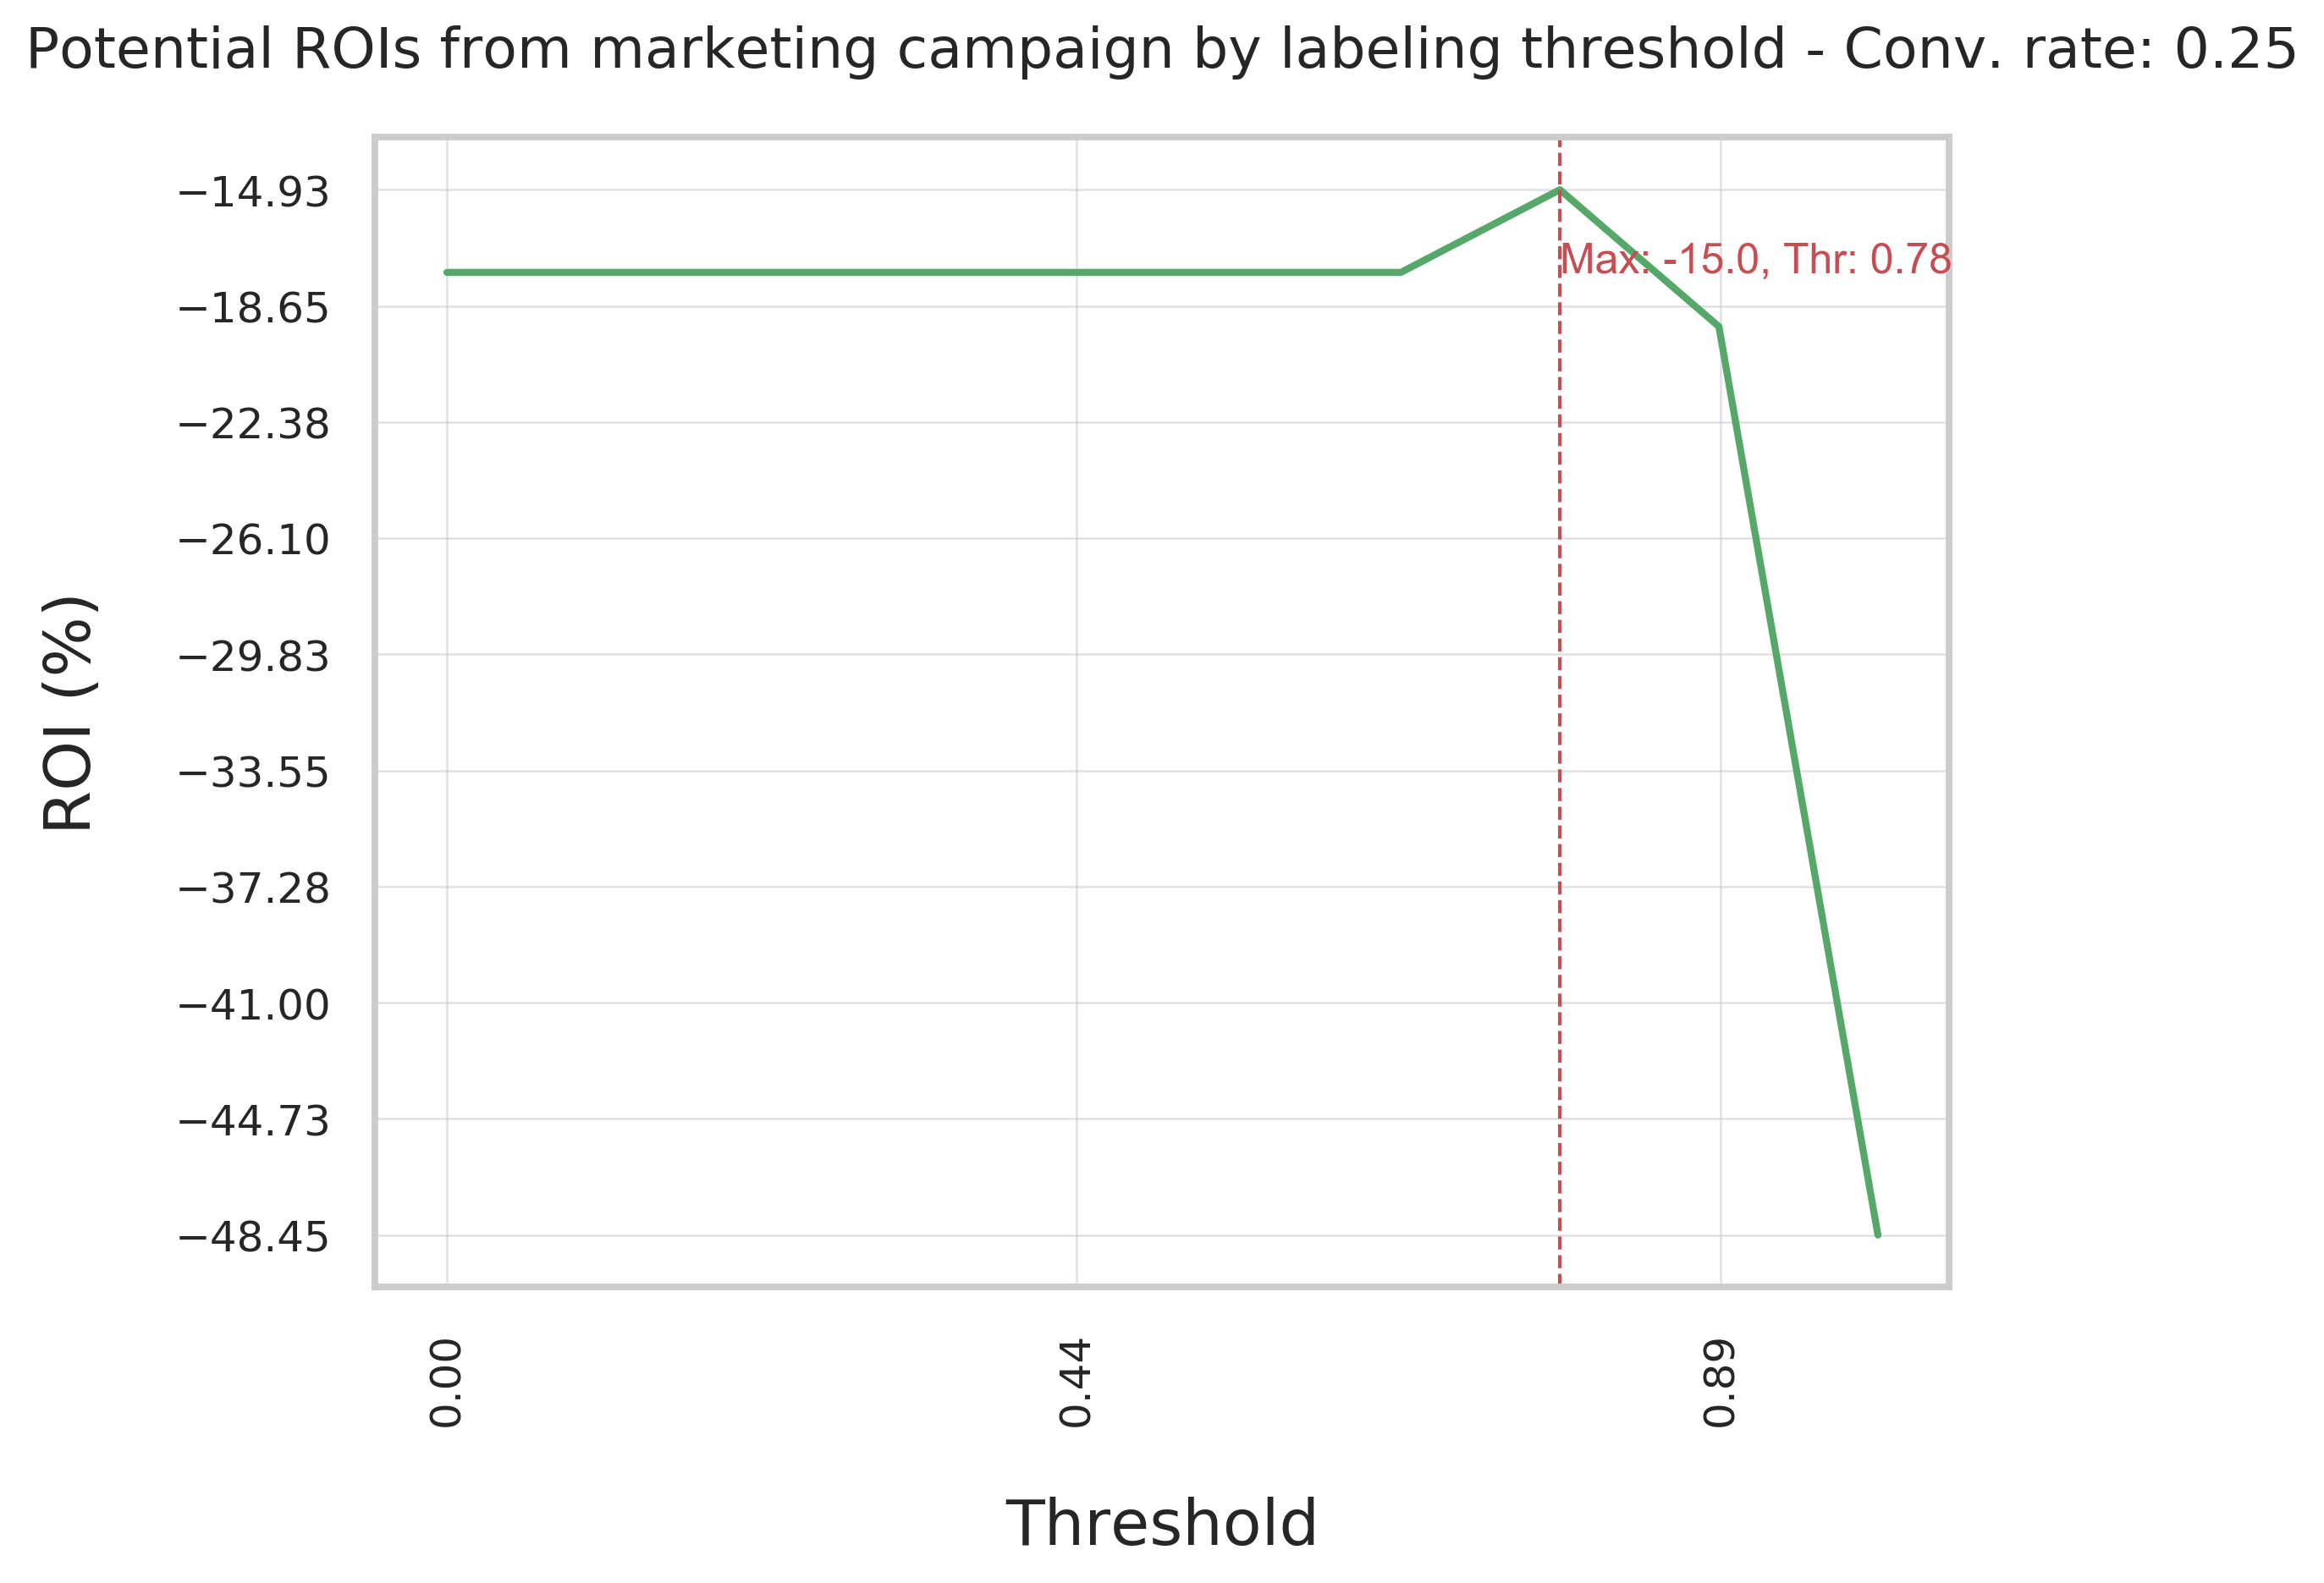

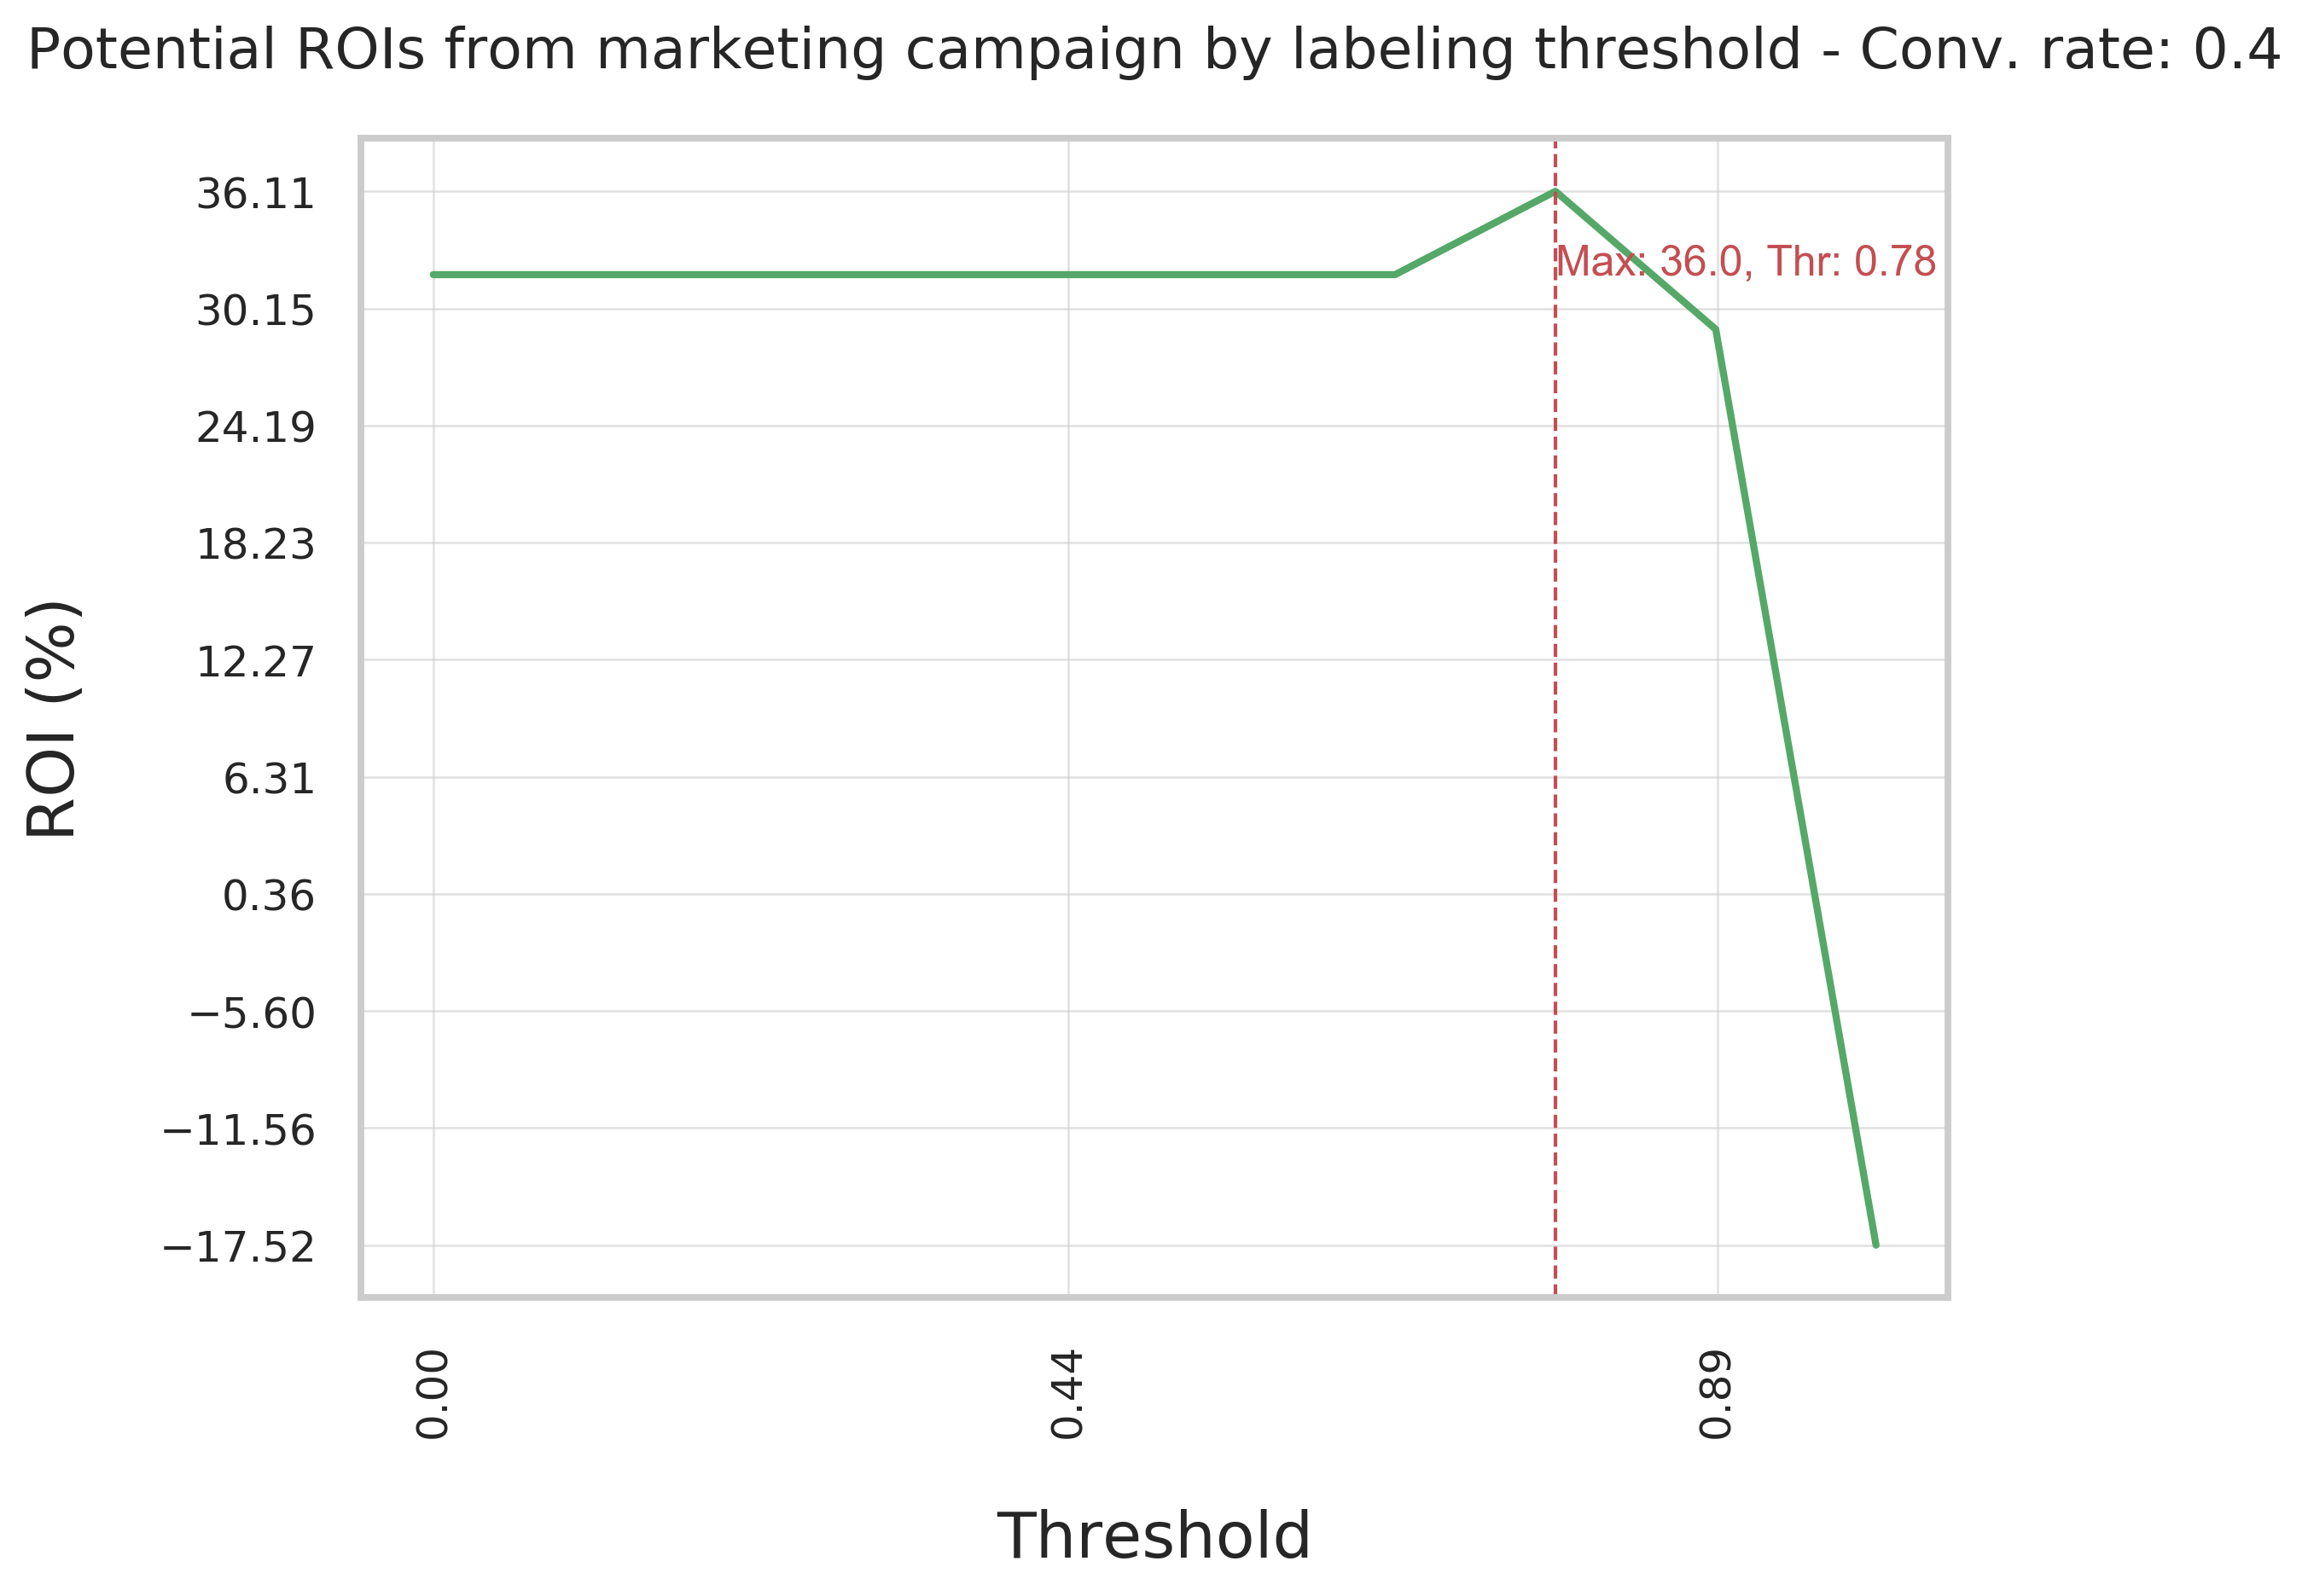

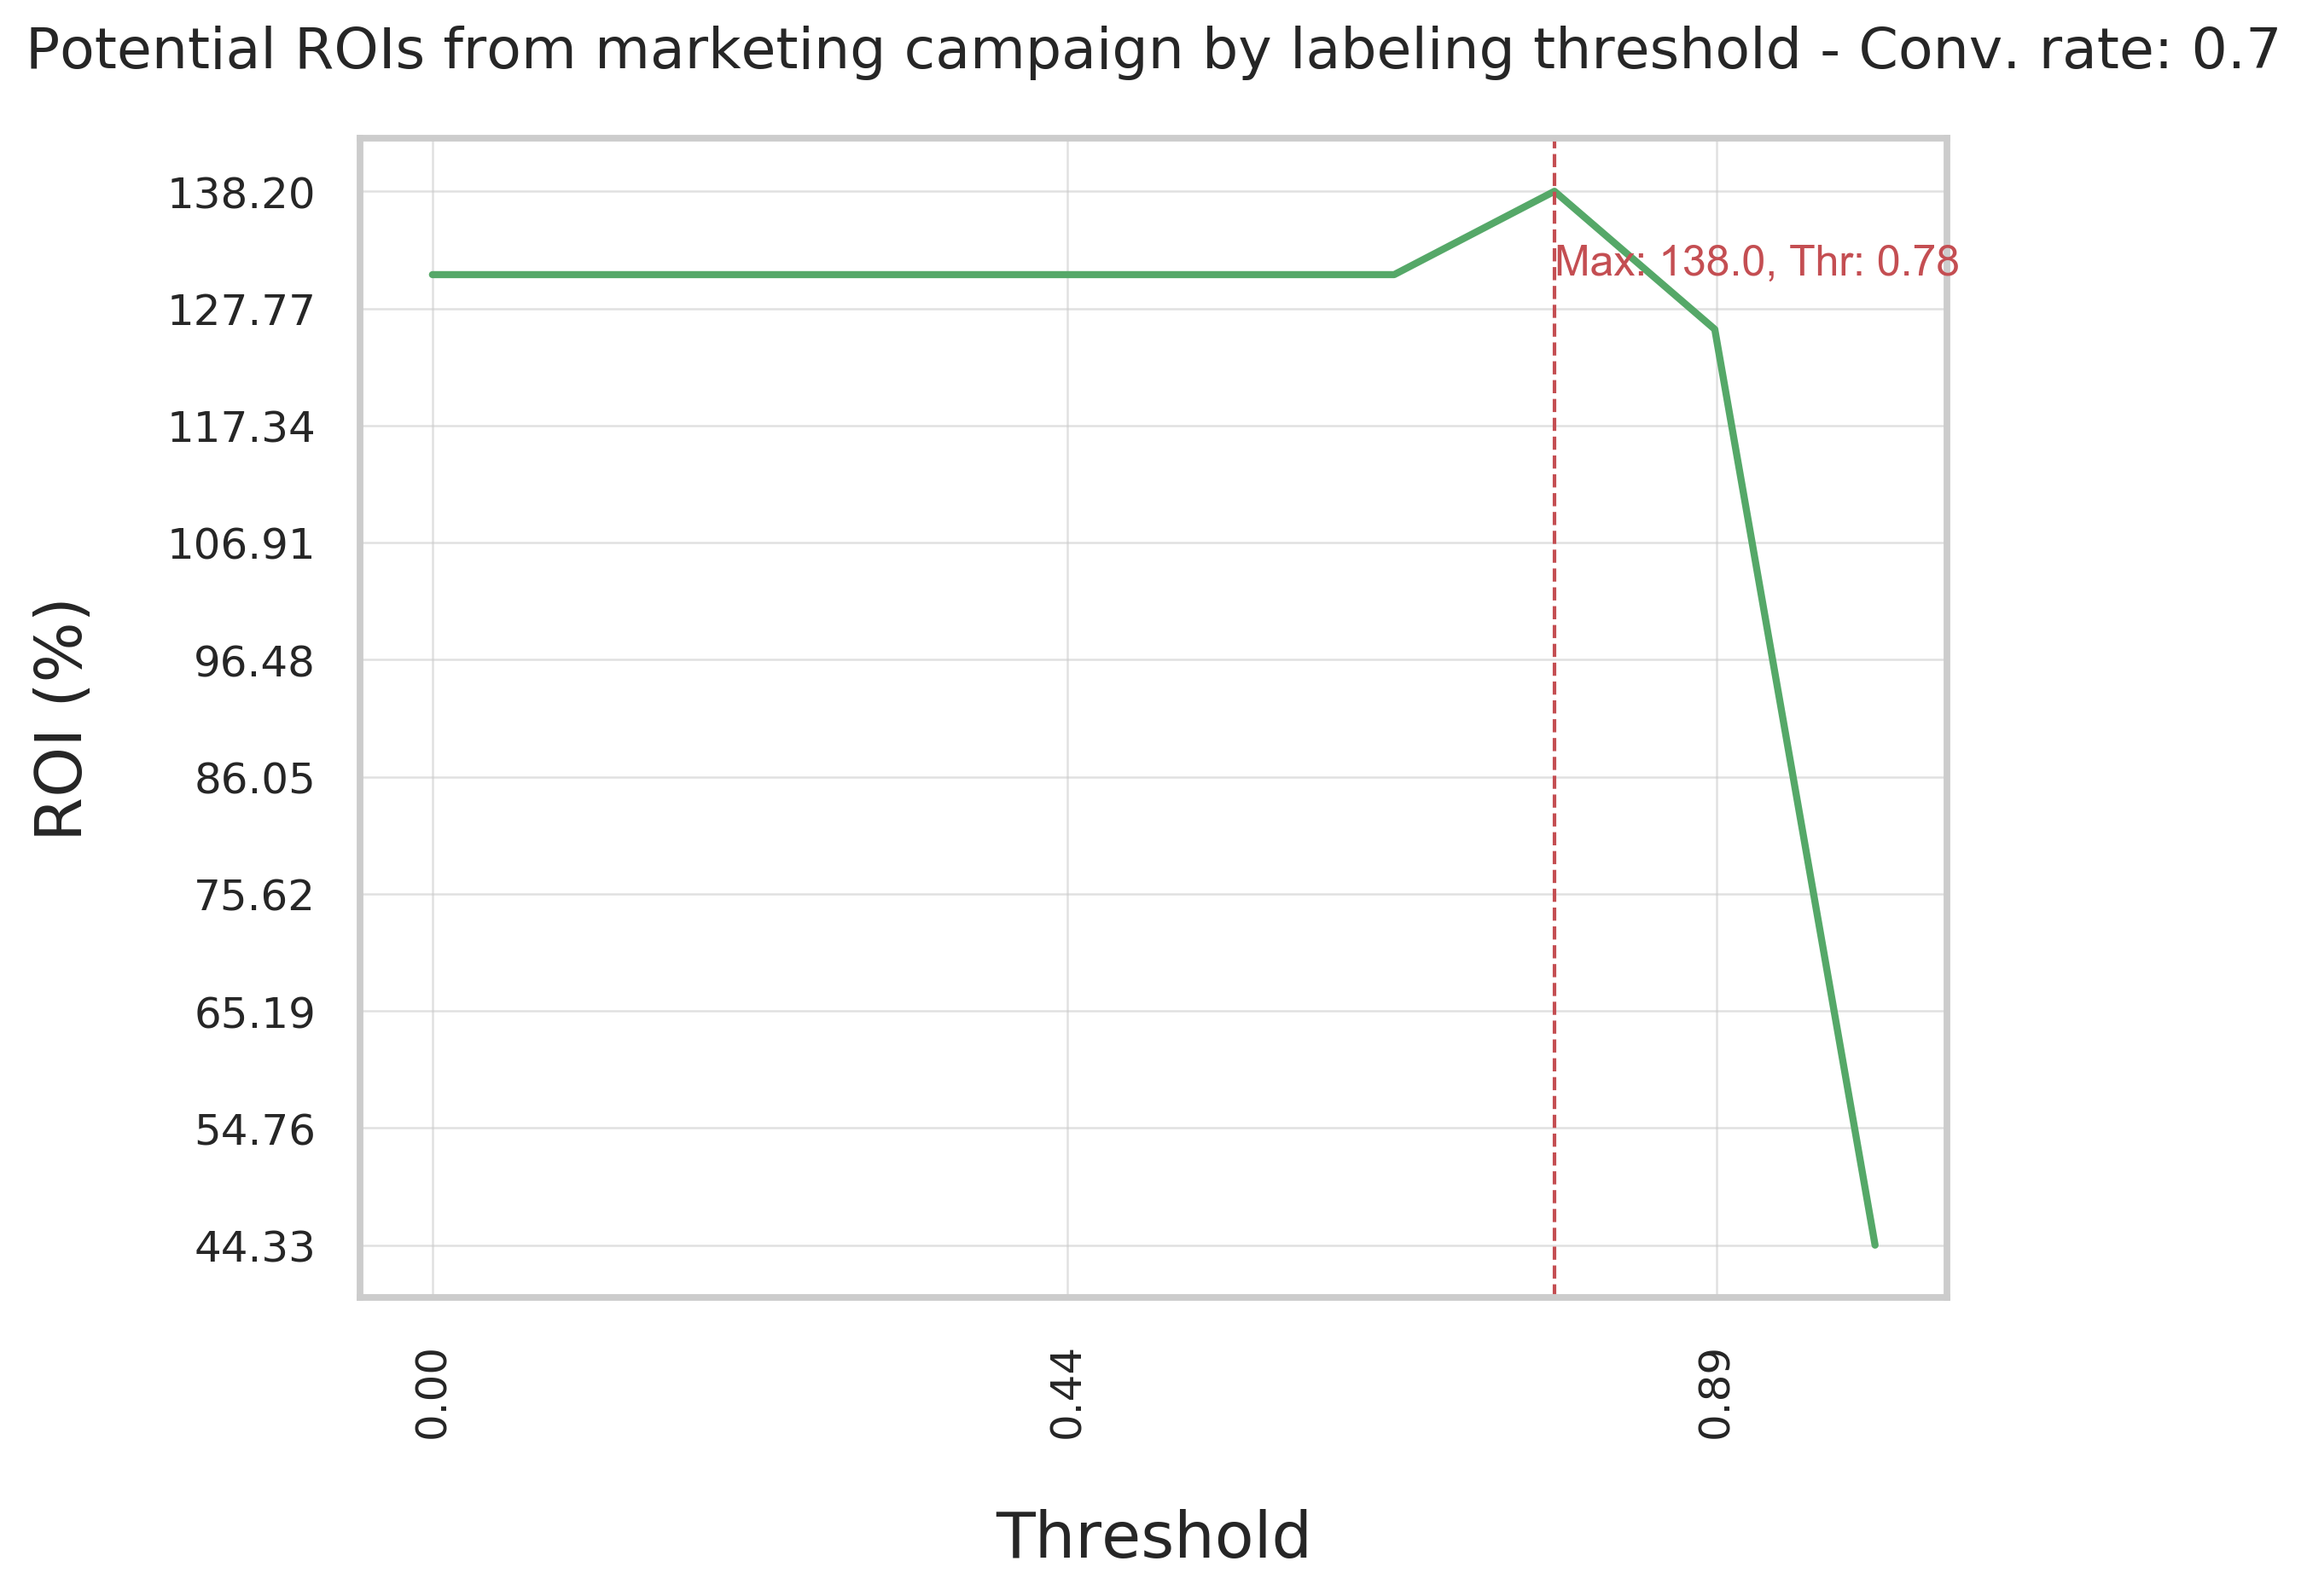

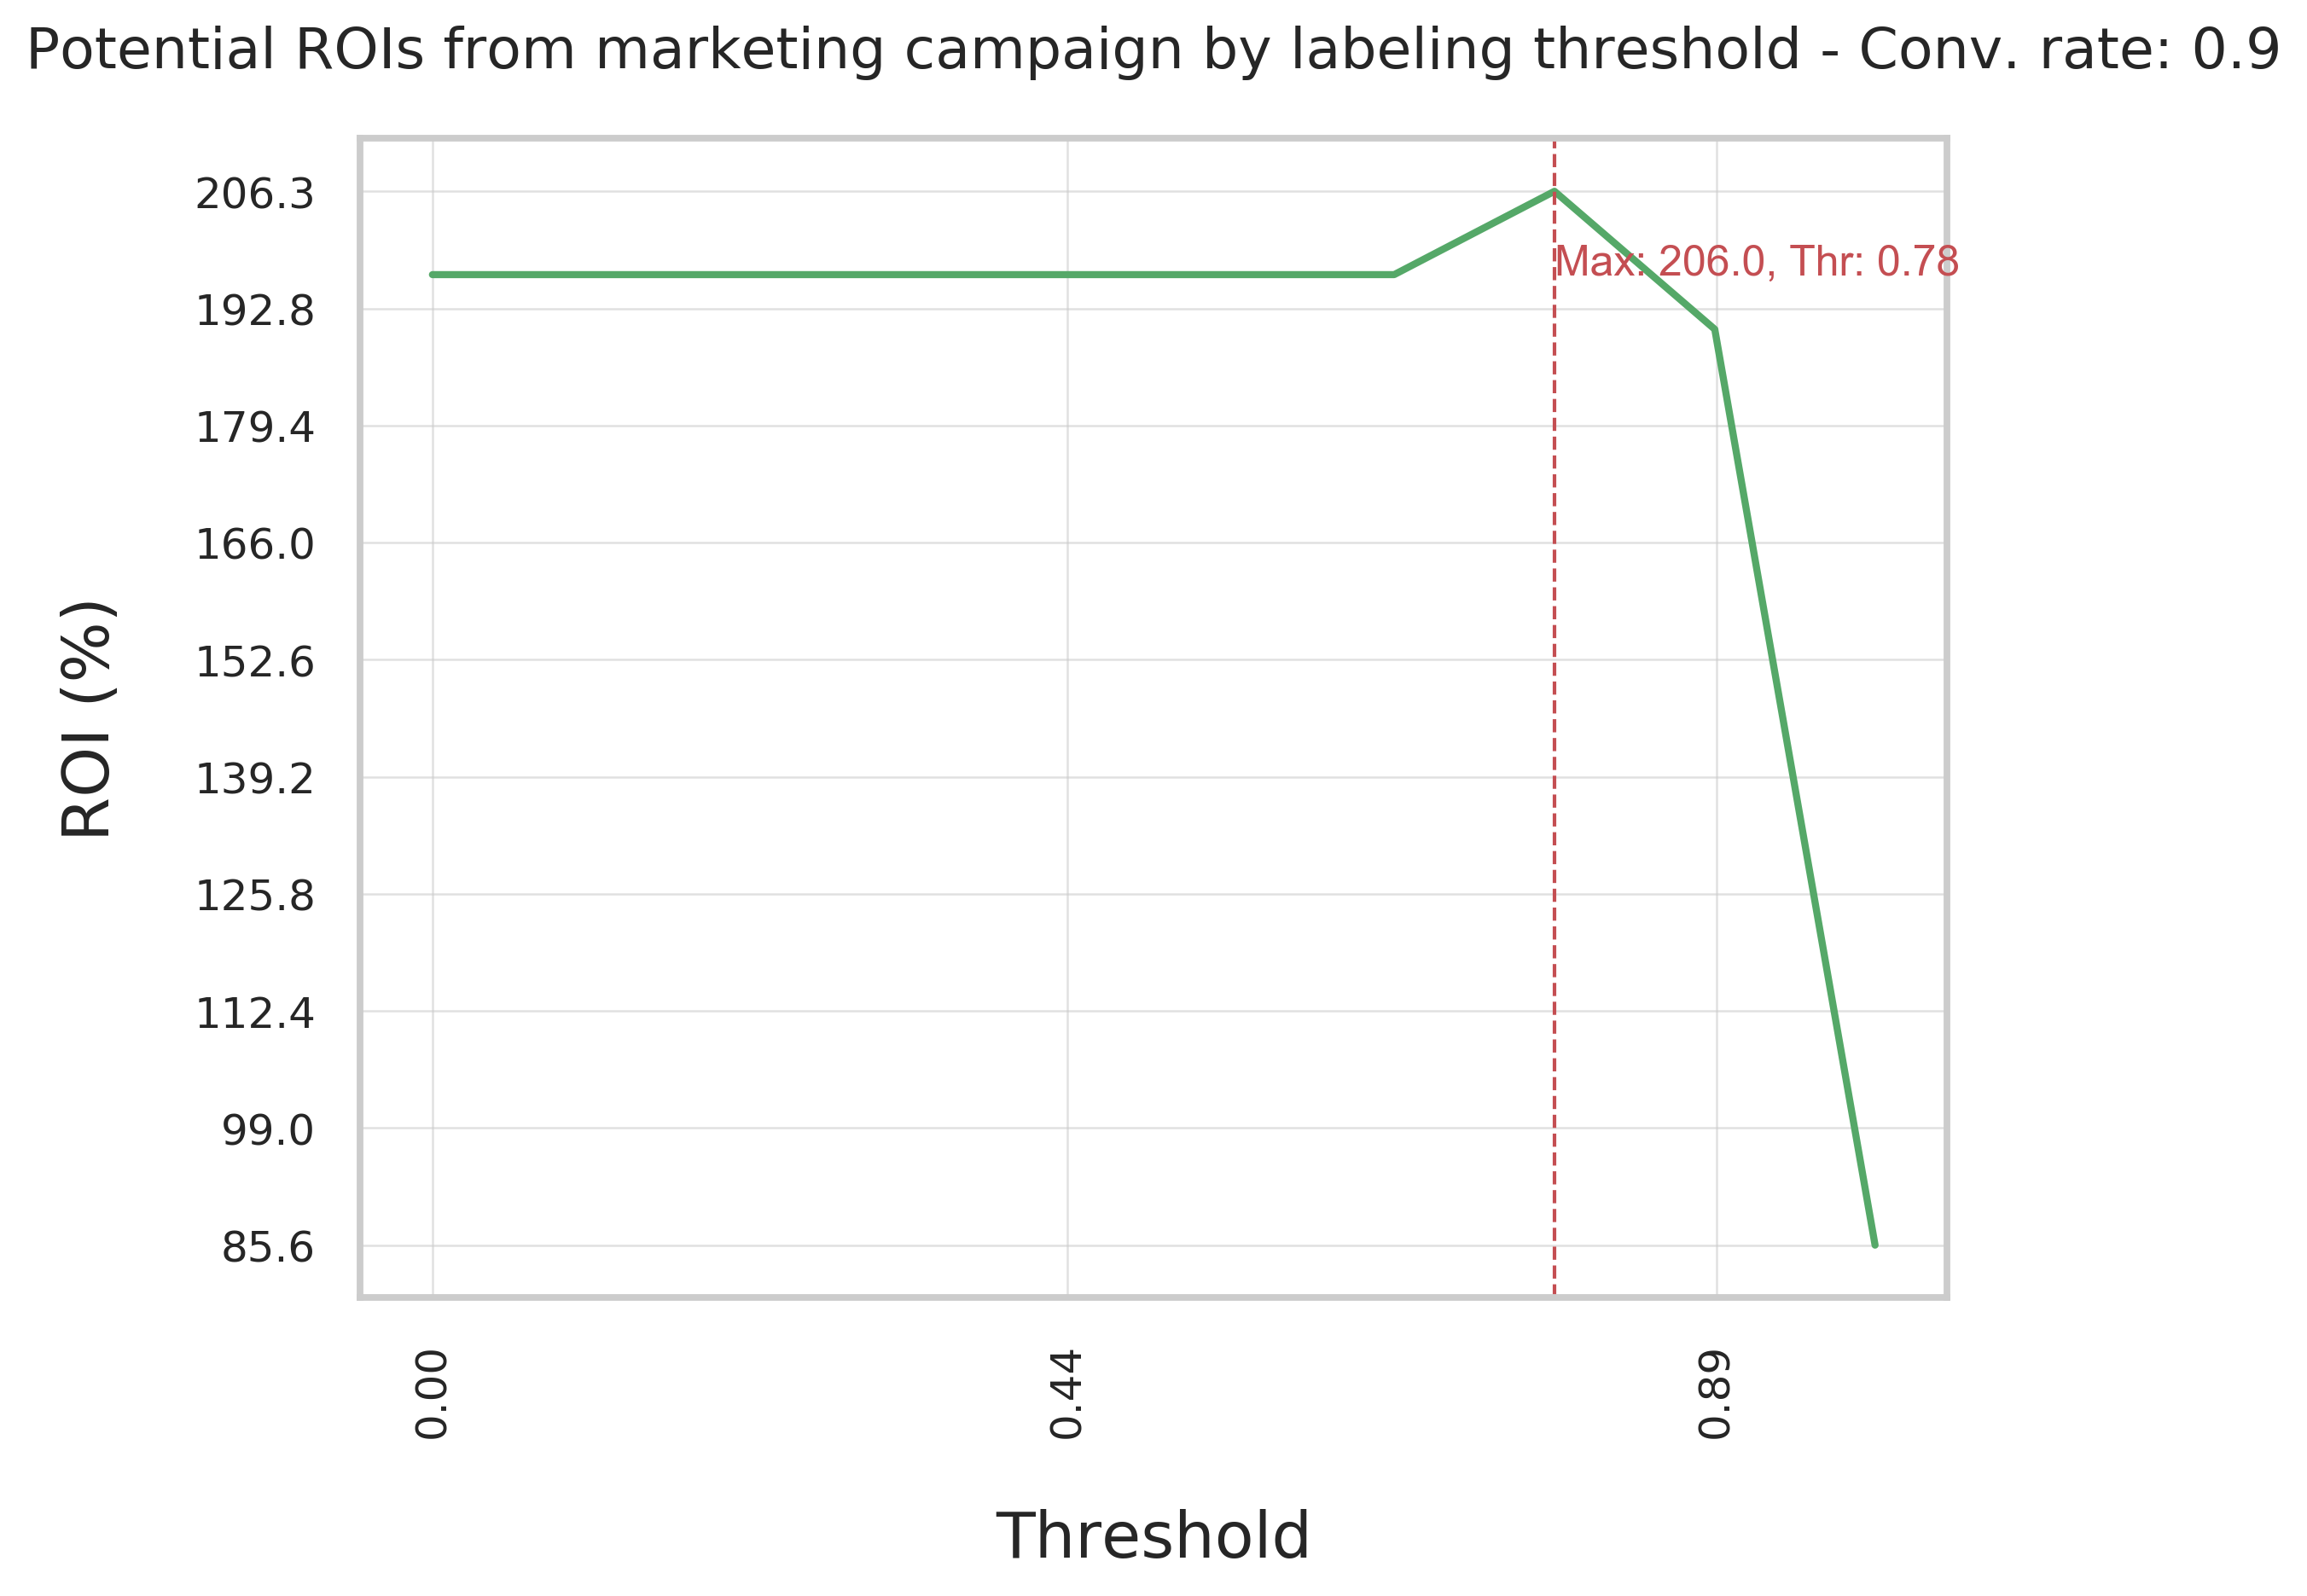

In [597]:
for conv_rate in conv_rates:
    ROI = [(x/y)*100 for x, y in zip(profs[conv_rate],costs[conv_rate])]
    title = 'Potential ROIs from marketing campaign by labeling threshold - Conv. rate: {}'.format(conv_rate)

    plt.figure(figsize=(8,6), dpi=300)
    sns.lineplot(x=thrs, y=ROI, color='g')
    plt.axvline(thrs[index_max], linestyle='--', linewidth=1, color='r')
    plt.text(thrs[index_max], ROI[0], 'Max: {}, Thr: {}'.format(np.round(np.max(ROI), 0), np.round(thrs[index_max][0], 2)), fontsize=12,
                   rotation=0,rotation_mode='anchor', color='r')

    fonttitle = {'fontname': 'Quicksand'}
    plt.title(title, pad=20, **fonttitle, fontsize=16)
    plt.xticks(ticks=np.round(thrs[::4],2), rotation=90, **fonttitle, fontsize=12);
    plt.yticks(ticks=np.linspace(np.min(ROI),np.max(ROI), 10), **fonttitle, fontsize=12);
    plt.xlabel('Threshold', labelpad=20, **fonttitle)
    plt.ylabel('ROI (%)', labelpad=20, **fonttitle);
    plt.grid(alpha=0.6, linewidth=0.6)

    plt.savefig('./images/{}.png'.format(title), bbox_inches = "tight")

## Feature importance

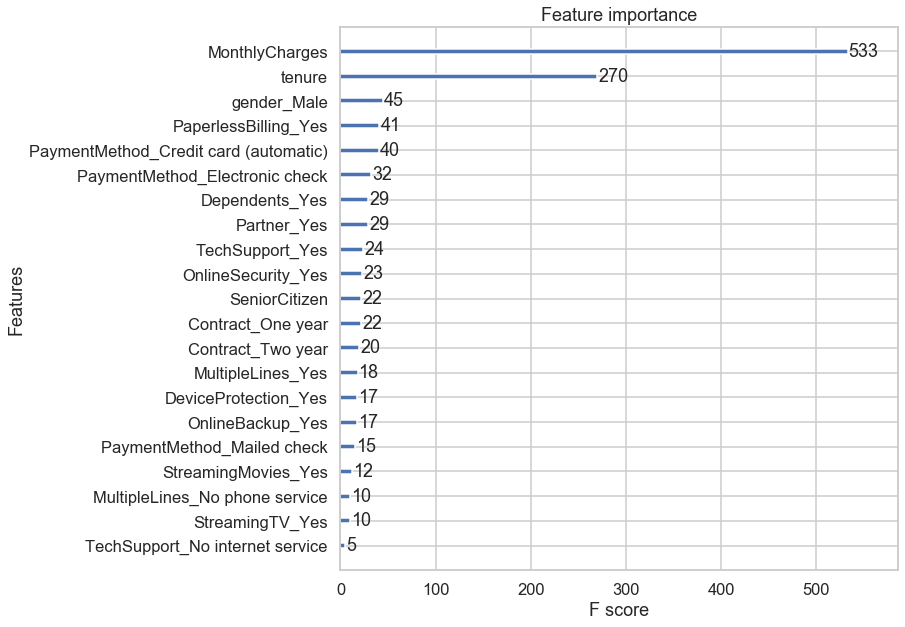

In [449]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xgbclassifier, ax=ax);